## What's this TensorFlow business?

You've written a lot of code in this assignment to provide a whole host of neural network functionality. Dropout, Batch Norm, and 2D convolutions are some of the workhorses of deep learning in computer vision. You've also worked hard to make your code efficient and vectorized.

For the last part of this assignment, though, we're going to leave behind your beautiful codebase and instead migrate to one of two popular deep learning frameworks: in this instance, TensorFlow (or PyTorch, if you switch over to that notebook)

#### What is it?
TensorFlow is a system for executing computational graphs over Tensor objects, with native support for performing backpropogation for its Variables. In it, we work with Tensors which are n-dimensional arrays analogous to the numpy ndarray.

#### Why?

* Our code will now run on GPUs! Much faster training. Writing your own modules to run on GPUs is beyond the scope of this class, unfortunately.
* We want you to be ready to use one of these frameworks for your project so you can experiment more efficiently than if you were writing every feature you want to use by hand. 
* We want you to stand on the shoulders of giants! TensorFlow and PyTorch are both excellent frameworks that will make your lives a lot easier, and now that you understand their guts, you are free to use them :) 
* We want you to be exposed to the sort of deep learning code you might run into in academia or industry. 

## How will I learn TensorFlow?

TensorFlow has many excellent tutorials available, including those from [Google themselves](https://www.tensorflow.org/get_started/get_started).

Otherwise, this notebook will walk you through much of what you need to do to train models in TensorFlow. See the end of the notebook for some links to helpful tutorials if you want to learn more or need further clarification on topics that aren't fully explained here.

## Load Datasets


In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Example Model

### Some useful utilities

. Remember that our image data is initially N x H x W x C, where:
* N is the number of datapoints
* H is the height of each image in pixels
* W is the height of each image in pixels
* C is the number of channels (usually 3: R, G, B)

This is the right way to represent the data when we are doing something like a 2D convolution, which needs spatial understanding of where the pixels are relative to each other. When we input image data into fully connected affine layers, however, we want each data example to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data.

### The example model itself

The first step to training your own model is defining its architecture.

Here's an example of a convolutional neural network defined in TensorFlow -- try to understand what each line is doing, remembering that each layer is composed upon the previous layer. We haven't trained anything yet - that'll come next - for now, we want you to understand how everything gets set up. 

In that example, you see 2D convolutional layers (Conv2d), ReLU activations, and fully-connected layers (Linear). You also see the Hinge loss function, and the Adam optimizer being used. 

Make sure you understand why the parameters of the Linear layer are 5408 and 10.

### TensorFlow Details
In TensorFlow, much like in our previous notebooks, we'll first specifically initialize our variables, and then our network model.

In [3]:
# clear old variables
tf.reset_default_graph()

# setup input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

def simple_model(X,y):
    # define our weights (e.g. init_two_layer_convnet)
    
    # setup variables
    Wconv1 = tf.get_variable("Wconv1", shape=[7, 7, 3, 32])
    bconv1 = tf.get_variable("bconv1", shape=[32])
    W1 = tf.get_variable("W1", shape=[5408, 10])
    b1 = tf.get_variable("b1", shape=[10])

    # define our graph (e.g. two_layer_convnet)
    a1 = tf.nn.conv2d(X, Wconv1, strides=[1,2,2,1], padding='VALID') + bconv1
    h1 = tf.nn.relu(a1)
    h1_flat = tf.reshape(h1,[-1,5408])
    y_out = tf.matmul(h1_flat,W1) + b1
    return y_out

y_out = simple_model(X,y)

# define our loss
total_loss = tf.losses.hinge_loss(tf.one_hot(y,10),logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
train_step = optimizer.minimize(mean_loss)

TensorFlow supports many other layer types, loss functions, and optimizers - you will experiment with these next. Here's the official API documentation for these (if any of the parameters used above were unclear, this resource will also be helpful). 

* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers
* BatchNorm: https://www.tensorflow.org/api_docs/python/tf/layers/batch_normalization

### Training the model on one epoch
While we have defined a graph of operations above, in order to execute TensorFlow Graphs, by feeding them input data and computing the results, we first need to create a `tf.Session` object. A session encapsulates the control and state of the TensorFlow runtime. For more information, see the TensorFlow [Getting started](https://www.tensorflow.org/get_started/get_started) guide.

Optionally we can also specify a device context such as `/cpu:0` or `/gpu:0`. For documentation on this behavior see [this TensorFlow guide](https://www.tensorflow.org/tutorials/using_gpu)

You should see a validation loss of around 0.4 to 0.6 and an accuracy of 0.30 to 0.35 below

Training
Iteration 0: with minibatch training loss = 7.94 and accuracy of 0.062
Iteration 100: with minibatch training loss = 1.14 and accuracy of 0.17
Iteration 200: with minibatch training loss = 0.845 and accuracy of 0.19
Iteration 300: with minibatch training loss = 0.697 and accuracy of 0.28
Iteration 400: with minibatch training loss = 0.519 and accuracy of 0.42
Iteration 500: with minibatch training loss = 0.477 and accuracy of 0.39
Iteration 600: with minibatch training loss = 0.435 and accuracy of 0.38
Iteration 700: with minibatch training loss = 0.353 and accuracy of 0.33
Epoch 1, Overall loss = 0.735 and accuracy of 0.312


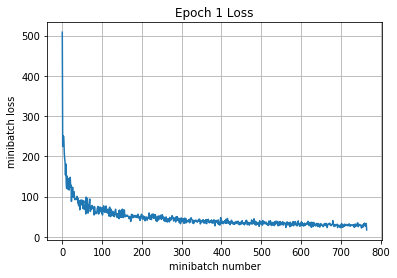

Validation
Epoch 1, Overall loss = 0.461 and accuracy of 0.343


In [4]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = []
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

with tf.Session() as sess:
    with tf.device("/cpu:0"): #"/cpu:0" or "/gpu:0" 
        sess.run(tf.global_variables_initializer())
        print('Training')
        run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step,True)
        print('Validation')
        run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

## Training a specific model

In this section, we're going to specify a model for you to construct. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow documentation and configuring your own model. 

Using the code provided above as guidance, and using the following TensorFlow documentation, specify a model with the following architecture:

* 7x7 Convolutional Layer with 32 filters and stride of 1
* ReLU Activation Layer
* Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
* 2x2 Max Pooling layer with a stride of 2
* Affine layer with 1024 output units
* ReLU Activation Layer
* Affine layer from 1024 input units to 10 outputs



In [5]:
# clear old variables
tf.reset_default_graph()

# define our input (e.g. the data that changes every batch)
# The first dim is None, and gets sets automatically based on batch size fed in
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

# define model
def complex_model(X,y,is_training):

    Wconv1 = tf.get_variable('Wconv1', shape = [7, 7, 3, 32])
    bconv1 = tf.get_variable('bconv1', shape = [32])
    #   out = [N, 26, 26, 32]
    # After maxpool:
    #   out = [N, 13, 13, 32]
    W1 = tf.get_variable('W1', shape = [5408, 1024])
    b1 = tf.get_variable('b1', shape = [1024, ])
    W2 = tf.get_variable('W2', shape = [1024, 10])
    b2 = tf.get_variable('b2', shape = [10, ])

    a1 = tf.nn.conv2d(X, Wconv1, strides = [1, 1, 1, 1], padding = 'VALID') + bconv1
    h1 = tf.nn.relu(a1)
    bn1 = tf.layers.batch_normalization(h1, training = is_training)
    mp1 = tf.nn.max_pool(bn1, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')
    mp1_flat = tf.reshape(mp1, [-1, 5408])
    d1 = tf.matmul(mp1_flat, W1) + b1
    h2 = tf.nn.relu(d1)
    out = tf.matmul(h2, W2) + b2
   
    return out

y_out = complex_model(X,y,is_training)


# define our loss
# loss = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), logits = y_out)

# define our optimizer
# optimizer = tf.train.AdamOptimizer(5e-4) # select optimizer and set learning rate
# update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# with tf.control_dependencies(update_ops):
#    train_step = optimizer.minimize(loss)

To make sure you're doing the right thing, use the following tool to check the dimensionality of your output (it should be 64 x 10, since our batches have size 64 and the output of the final affine layer should be 10, corresponding to our 10 classes):

In [6]:
# Now we're going to feed a random batch into the model 
# and make sure the output is the right size
x = np.random.randn(64, 32, 32,3)
with tf.Session() as sess:
    with tf.device("/gpu:0"): #"/cpu:0" or "/gpu:0"
        tf.global_variables_initializer().run()

        ans = sess.run(y_out,feed_dict={X:x,is_training:True})
        %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
        print(ans.shape)
        print(np.array_equal(ans.shape, np.array([64, 10])))

2.24 ms ± 182 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
(64, 10)
True


You should see the following from the run above 

`(64, 10)`

`True`

### GPU!

Now, we're going to try and start the model under the GPU device, the rest of the code stays unchanged and all our variables and operations will be computed using accelerated code paths. However, if there is no GPU, we get a Python exception and have to rebuild our graph. On a dual-core CPU, you might see around 50-80ms/batch running the above, while the Google Cloud GPUs (run below) should be around 2-5ms/batch.

In [7]:
try:
    with tf.Session() as sess:
        with tf.device("/gpu:0") as dev: #"/cpu:0" or "/gpu:0"
            tf.global_variables_initializer().run()

            ans = sess.run(y_out,feed_dict={X:x,is_training:True})
            %timeit sess.run(y_out,feed_dict={X:x,is_training:True})
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration")    
    # rebuild the graph
    # trying to start a GPU throws an exception 
    # and also trashes the original graph
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, [None, 32, 32, 3])
    y = tf.placeholder(tf.int64, [None])
    is_training = tf.placeholder(tf.bool)
    y_out = complex_model(X,y,is_training)

2.07 ms ± 11.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


You should observe that even a simple forward pass like this is significantly faster on the GPU. So for the rest of the assignment (and when you go train your models in assignment 3 and your project!), you should use GPU devices. However, with TensorFlow, the default device is a GPU if one is available, and a CPU otherwise, so we can skip the device specification from now on.

### Train the model.

Now that you've seen how to define a model and do a single forward pass of some data through it, let's  walk through how you'd actually train one whole epoch over your training data (using the complex_model you created provided above).

Make sure you understand how each TensorFlow function used below corresponds to what you implemented in your custom neural network implementation.

First, set up an **RMSprop optimizer** (using a 1e-3 learning rate) and a **cross-entropy loss** function. See the TensorFlow documentation for more information
* Layers, Activations, Loss functions : https://www.tensorflow.org/api_guides/python/nn
* Optimizers: https://www.tensorflow.org/api_guides/python/train#Optimizers

In [8]:
# Inputs
#     y_out: is what your model computes
#     y: is your TensorFlow variable with label information
# Outputs
#    mean_loss: a TensorFlow variable (scalar) with numerical loss
#    optimizer: a TensorFlow optimizer
# This should be ~3 lines of code!
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = tf.one_hot(y, 10), logits = y_out))
optimizer = tf.train.RMSPropOptimizer(1e-3)

In [9]:
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

### Train the model
Below we'll create a session and train the model over one epoch. You should see a loss of 1.4 to 2.0 and an accuracy of 0.4 to 0.5. There will be some variation due to random seeds and differences in initialization

In [10]:
sess = tf.Session()

sess.run(tf.global_variables_initializer())
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64,100,train_step)

Training
Iteration 0: with minibatch training loss = 3.23 and accuracy of 0.11
Iteration 100: with minibatch training loss = 2.61 and accuracy of 0.28
Iteration 200: with minibatch training loss = 1.87 and accuracy of 0.5
Iteration 300: with minibatch training loss = 1.53 and accuracy of 0.45
Iteration 400: with minibatch training loss = 1.64 and accuracy of 0.52
Iteration 500: with minibatch training loss = 1.49 and accuracy of 0.52
Iteration 600: with minibatch training loss = 1.27 and accuracy of 0.58
Iteration 700: with minibatch training loss = 1.47 and accuracy of 0.5
Epoch 1, Overall loss = 1.68 and accuracy of 0.451


(1.6810092473905913, 0.45063265306122446)

### Check the accuracy of the model.

Let's see the train and test code in action -- feel free to use these methods when evaluating the models you develop below. You should see a loss of 1.3 to 2.0 with an accuracy of 0.45 to 0.55.

In [11]:
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Validation
Epoch 1, Overall loss = 1.38 and accuracy of 0.529


(1.3763549213409423, 0.529)

## Train a _great_ model on CIFAR-10!

Now it's your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves ** >= 70% accuracy on the validation set** of CIFAR-10. You can use the `run_model` function from above.

### Things you should try:
- **Filter size**: Above we used 7x7; this makes pretty pictures but smaller filters may be more efficient
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Use TensorFlow Scope**: Use TensorFlow scope and/or [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to make it easier to write deeper networks. See [this tutorial](https://www.tensorflow.org/tutorials/layers) for how to use `tf.layers`. 
- **Use Learning Rate Decay**: [As the notes point out](http://cs231n.github.io/neural-networks-3/#anneal), decaying the learning rate might help the model converge. Feel free to decay every epoch, when loss doesn't change over an entire epoch, or any other heuristic you find appropriate. See the [Tensorflow documentation](https://www.tensorflow.org/versions/master/api_guides/python/train#Decaying_the_learning_rate) for learning rate decay.
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use [Dropout as in the TensorFlow MNIST tutorial](https://www.tensorflow.org/get_started/mnist/pros)

### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)

If you do decide to implement something extra, clearly describe it in the "Extra Credit Description" cell below.

### What we expect
At the very least, you should be able to train a ConvNet that gets at **>= 70% accuracy on the validation set**. This is just a lower bound - if you are careful it should be possible to get accuracies much higher than that! Extra credit points will be awarded for particularly high-scoring models or unique approaches.

You should use the space below to experiment and train your network. The final cell in this notebook should contain the training and validation set accuracies for your final trained network.

Have fun and happy training!

In [12]:
## Feel free to play with this cell

def my_model(X,y,is_training):

    out = tf.layers.conv2d(inputs = X,
                           filters = 96,
                           kernel_size = [3, 3],
                           padding = 'SAME',
                           activation = tf.nn.relu)
    
    out = tf.layers.conv2d(inputs = out,
                           filters = 96,
                           kernel_size = [2, 2],
                           padding = 'SAME',
                           activation = tf.nn.relu)

    out = tf.layers.batch_normalization(inputs = out, 
                                        training = is_training)
    
    out = tf.layers.max_pooling2d(inputs = out,
                                  pool_size = [2, 2],
                                  strides = 2)
    
    # end of part 1
    
    out = tf.layers.conv2d(inputs = out,
                           filters = 128,
                           kernel_size = [2, 2],
                           padding = 'SAME',
                           activation = tf.nn.relu)
    
    out = tf.layers.conv2d(inputs = out,
                           filters = 128,
                           kernel_size = [2, 2],
                           padding = 'SAME',
                           activation = tf.nn.relu)
    
    out = tf.layers.conv2d(inputs = out,
                           filters = 128,
                           kernel_size = [2, 2],
                           padding = 'SAME',
                           activation = tf.nn.relu)
    
    
    out = tf.layers.batch_normalization(inputs = out, 
                                        training = is_training)
    
    out = tf.layers.max_pooling2d(inputs = out,
                                  pool_size = [2, 2],
                                  strides = 2)

    # end of part 2
    
    out = tf.layers.conv2d(inputs = out,
                           filters = 256,
                           kernel_size = [2, 2],
                           padding = 'SAME',
                           activation = tf.nn.relu)
    
    out = tf.layers.conv2d(inputs = out,
                           filters = 256,
                           kernel_size = [2, 2],
                           padding = 'SAME',
                           activation = tf.nn.relu)
    
    out = tf.layers.conv2d(inputs = out,
                           filters = 256,
                           kernel_size = [2, 2],
                           padding = 'SAME',
                           activation = tf.nn.relu)
    
    out = tf.layers.batch_normalization(inputs = out, 
                                        training = is_training)
    
    out = tf.layers.max_pooling2d(inputs = out,
                                  pool_size = [2, 2],
                                  strides = 2)
    
    # end of part 3
    
    
    out = tf.layers.conv2d(inputs = out,
                           filters = 512,
                           kernel_size = [2, 2],
                           padding = 'SAME',
                           activation = tf.nn.relu)
    
    out = tf.layers.conv2d(inputs = out,
                           filters = 512,
                           kernel_size = [2, 2],
                           padding = 'SAME',
                           activation = tf.nn.relu)
    
    out = tf.layers.conv2d(inputs = out,
                           filters = 512,
                           kernel_size = [2, 2],
                           padding = 'SAME',
                           activation = tf.nn.relu)
    
    out = tf.layers.batch_normalization(inputs = out, 
                                        training = is_training)

    # end of part 4
    
    out = tf.layers.flatten(inputs = out)
    
    # 4096
    out = tf.layers.dense(inputs = out,
                          units = 4096,
                          activation = tf.nn.relu)
    out = tf.layers.dropout(inputs = out,
                            rate = 0.5)
    out = tf.layers.batch_normalization(inputs = out,
                                        training = is_training)
    
    # 4096
    out = tf.layers.dense(inputs = out,
                          units = 4096,
                          activation = tf.nn.relu)
    out = tf.layers.dropout(inputs = out,
                            rate = 0.5)
    out = tf.layers.batch_normalization(inputs = out,
                                        training = is_training)
    
    # 1024
    out = tf.layers.dense(inputs = out,
                          units = 1024,
                          activation = tf.nn.relu)
    out = tf.layers.dropout(inputs = out,
                            rate = 0.5)
    out = tf.layers.batch_normalization(inputs = out,
                                        training = is_training)
    
    # 10
    out = tf.layers.dense(inputs = out,
                          units = 10)

    return out

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X, y, is_training)
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = tf.one_hot(y, 10), logits = y_out))
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-3)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 2.97 and accuracy of 0.12
Iteration 100: with minibatch training loss = 2.08 and accuracy of 0.27
Iteration 200: with minibatch training loss = 1.67 and accuracy of 0.34
Iteration 300: with minibatch training loss = 1.57 and accuracy of 0.5
Iteration 400: with minibatch training loss = 1.7 and accuracy of 0.34
Iteration 500: with minibatch training loss = 1.54 and accuracy of 0.45
Iteration 600: with minibatch training loss = 1.32 and accuracy of 0.47
Iteration 700: with minibatch training loss = 1.36 and accuracy of 0.47
Epoch 1, Overall loss = 1.63 and accuracy of 0.402


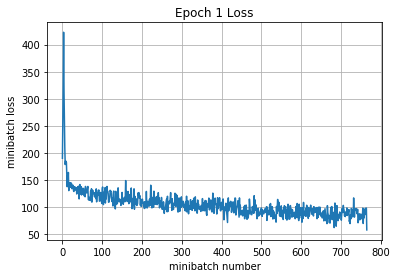

Iteration 800: with minibatch training loss = 1.21 and accuracy of 0.55
Iteration 900: with minibatch training loss = 1.5 and accuracy of 0.52
Iteration 1000: with minibatch training loss = 1.03 and accuracy of 0.72
Iteration 1100: with minibatch training loss = 1.28 and accuracy of 0.58
Iteration 1200: with minibatch training loss = 1.1 and accuracy of 0.53
Iteration 1300: with minibatch training loss = 1 and accuracy of 0.61
Iteration 1400: with minibatch training loss = 1.04 and accuracy of 0.64
Iteration 1500: with minibatch training loss = 0.854 and accuracy of 0.7
Epoch 2, Overall loss = 1.14 and accuracy of 0.591


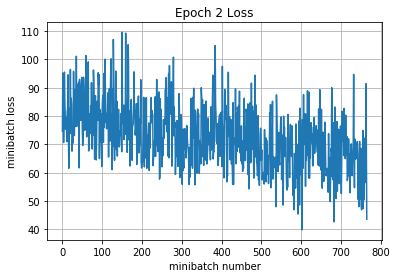

Iteration 1600: with minibatch training loss = 1.09 and accuracy of 0.62
Iteration 1700: with minibatch training loss = 1.11 and accuracy of 0.62
Iteration 1800: with minibatch training loss = 0.806 and accuracy of 0.7
Iteration 1900: with minibatch training loss = 0.825 and accuracy of 0.77
Iteration 2000: with minibatch training loss = 1.11 and accuracy of 0.64
Iteration 2100: with minibatch training loss = 1.21 and accuracy of 0.61
Iteration 2200: with minibatch training loss = 0.711 and accuracy of 0.81
Epoch 3, Overall loss = 0.931 and accuracy of 0.669


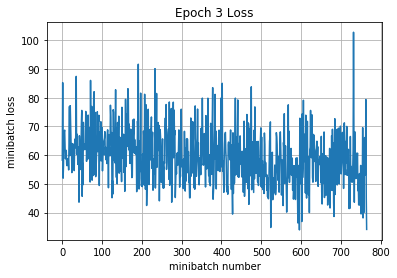

Iteration 2300: with minibatch training loss = 0.733 and accuracy of 0.75
Iteration 2400: with minibatch training loss = 0.953 and accuracy of 0.66
Iteration 2500: with minibatch training loss = 0.673 and accuracy of 0.8
Iteration 2600: with minibatch training loss = 0.913 and accuracy of 0.73
Iteration 2700: with minibatch training loss = 0.721 and accuracy of 0.75
Iteration 2800: with minibatch training loss = 0.832 and accuracy of 0.62
Iteration 2900: with minibatch training loss = 0.492 and accuracy of 0.88
Iteration 3000: with minibatch training loss = 0.746 and accuracy of 0.77
Epoch 4, Overall loss = 0.789 and accuracy of 0.723


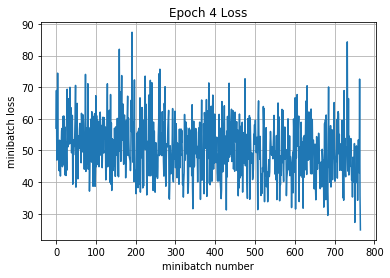

Iteration 3100: with minibatch training loss = 0.544 and accuracy of 0.84
Iteration 3200: with minibatch training loss = 0.59 and accuracy of 0.78
Iteration 3300: with minibatch training loss = 0.617 and accuracy of 0.77
Iteration 3400: with minibatch training loss = 0.631 and accuracy of 0.75
Iteration 3500: with minibatch training loss = 0.511 and accuracy of 0.8
Iteration 3600: with minibatch training loss = 0.644 and accuracy of 0.77
Iteration 3700: with minibatch training loss = 0.643 and accuracy of 0.77
Iteration 3800: with minibatch training loss = 0.57 and accuracy of 0.83
Epoch 5, Overall loss = 0.665 and accuracy of 0.769


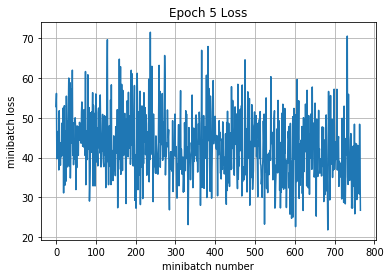

Iteration 3900: with minibatch training loss = 0.605 and accuracy of 0.75
Iteration 4000: with minibatch training loss = 0.546 and accuracy of 0.78
Iteration 4100: with minibatch training loss = 0.592 and accuracy of 0.78
Iteration 4200: with minibatch training loss = 0.469 and accuracy of 0.8
Iteration 4300: with minibatch training loss = 0.479 and accuracy of 0.83
Iteration 4400: with minibatch training loss = 0.68 and accuracy of 0.75
Iteration 4500: with minibatch training loss = 0.369 and accuracy of 0.89
Epoch 6, Overall loss = 0.572 and accuracy of 0.802


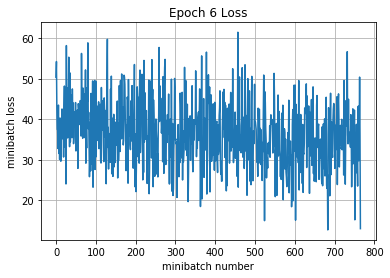

Iteration 4600: with minibatch training loss = 0.527 and accuracy of 0.81
Iteration 4700: with minibatch training loss = 0.582 and accuracy of 0.77
Iteration 4800: with minibatch training loss = 0.57 and accuracy of 0.83
Iteration 4900: with minibatch training loss = 0.315 and accuracy of 0.88
Iteration 5000: with minibatch training loss = 0.567 and accuracy of 0.8
Iteration 5100: with minibatch training loss = 0.484 and accuracy of 0.86
Iteration 5200: with minibatch training loss = 0.549 and accuracy of 0.78
Iteration 5300: with minibatch training loss = 0.439 and accuracy of 0.84
Epoch 7, Overall loss = 0.49 and accuracy of 0.831


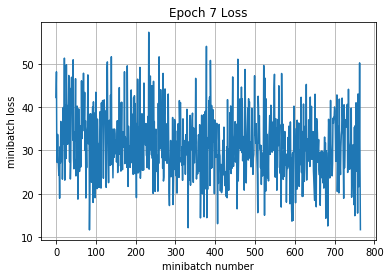

Iteration 5400: with minibatch training loss = 0.601 and accuracy of 0.8
Iteration 5500: with minibatch training loss = 0.364 and accuracy of 0.83
Iteration 5600: with minibatch training loss = 0.347 and accuracy of 0.84
Iteration 5700: with minibatch training loss = 0.341 and accuracy of 0.86
Iteration 5800: with minibatch training loss = 0.321 and accuracy of 0.86
Iteration 5900: with minibatch training loss = 0.327 and accuracy of 0.89
Iteration 6000: with minibatch training loss = 0.344 and accuracy of 0.88
Iteration 6100: with minibatch training loss = 0.358 and accuracy of 0.84
Epoch 8, Overall loss = 0.413 and accuracy of 0.86


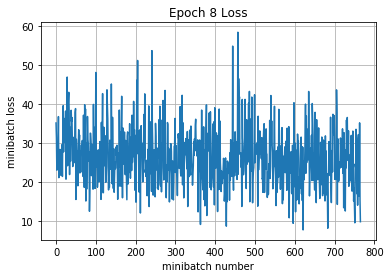

Iteration 6200: with minibatch training loss = 0.365 and accuracy of 0.91
Iteration 6300: with minibatch training loss = 0.444 and accuracy of 0.84
Iteration 6400: with minibatch training loss = 0.491 and accuracy of 0.83
Iteration 6500: with minibatch training loss = 0.204 and accuracy of 0.92
Iteration 6600: with minibatch training loss = 0.289 and accuracy of 0.91
Iteration 6700: with minibatch training loss = 0.171 and accuracy of 0.94
Iteration 6800: with minibatch training loss = 0.245 and accuracy of 0.89
Epoch 9, Overall loss = 0.343 and accuracy of 0.885


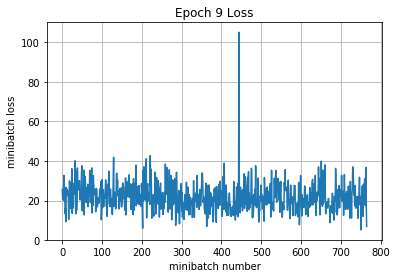

Iteration 6900: with minibatch training loss = 0.354 and accuracy of 0.83
Iteration 7000: with minibatch training loss = 0.375 and accuracy of 0.88
Iteration 7100: with minibatch training loss = 0.248 and accuracy of 0.91
Iteration 7200: with minibatch training loss = 0.264 and accuracy of 0.89
Iteration 7300: with minibatch training loss = 0.122 and accuracy of 0.95
Iteration 7400: with minibatch training loss = 0.376 and accuracy of 0.91
Iteration 7500: with minibatch training loss = 0.329 and accuracy of 0.89
Iteration 7600: with minibatch training loss = 0.326 and accuracy of 0.91
Epoch 10, Overall loss = 0.285 and accuracy of 0.903


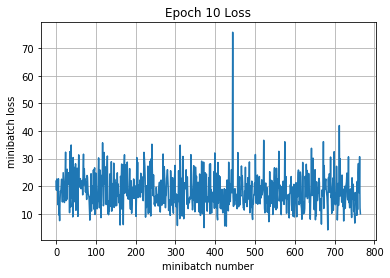

Iteration 7700: with minibatch training loss = 0.273 and accuracy of 0.91
Iteration 7800: with minibatch training loss = 0.128 and accuracy of 0.97
Iteration 7900: with minibatch training loss = 0.126 and accuracy of 0.95
Iteration 8000: with minibatch training loss = 0.173 and accuracy of 0.97
Iteration 8100: with minibatch training loss = 0.359 and accuracy of 0.89
Iteration 8200: with minibatch training loss = 0.372 and accuracy of 0.91
Iteration 8300: with minibatch training loss = 0.0963 and accuracy of 0.95
Iteration 8400: with minibatch training loss = 0.303 and accuracy of 0.91
Epoch 11, Overall loss = 0.232 and accuracy of 0.921


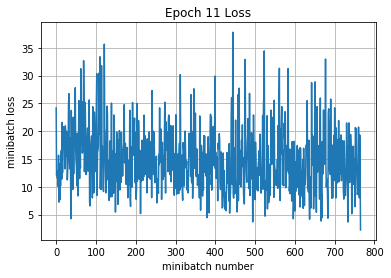

Iteration 8500: with minibatch training loss = 0.219 and accuracy of 0.94
Iteration 8600: with minibatch training loss = 0.129 and accuracy of 0.94
Iteration 8700: with minibatch training loss = 0.242 and accuracy of 0.91
Iteration 8800: with minibatch training loss = 0.131 and accuracy of 0.95
Iteration 8900: with minibatch training loss = 0.199 and accuracy of 0.91
Iteration 9000: with minibatch training loss = 0.337 and accuracy of 0.86
Iteration 9100: with minibatch training loss = 0.167 and accuracy of 0.94
Epoch 12, Overall loss = 0.203 and accuracy of 0.93


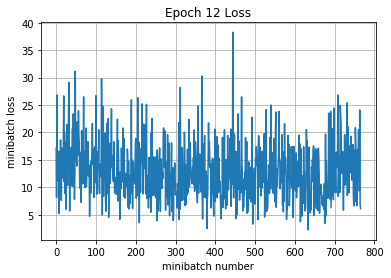

Iteration 9200: with minibatch training loss = 0.278 and accuracy of 0.88
Iteration 9300: with minibatch training loss = 0.131 and accuracy of 0.95
Iteration 9400: with minibatch training loss = 0.129 and accuracy of 0.97
Iteration 9500: with minibatch training loss = 0.236 and accuracy of 0.88
Iteration 9600: with minibatch training loss = 0.214 and accuracy of 0.94
Iteration 9700: with minibatch training loss = 0.17 and accuracy of 0.92
Iteration 9800: with minibatch training loss = 0.152 and accuracy of 0.95
Iteration 9900: with minibatch training loss = 0.191 and accuracy of 0.89
Epoch 13, Overall loss = 0.165 and accuracy of 0.943


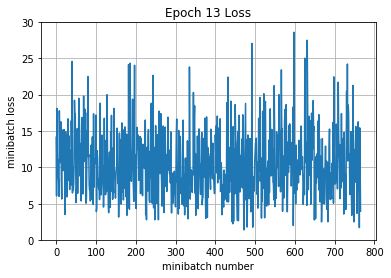

Iteration 10000: with minibatch training loss = 0.0694 and accuracy of 0.98
Iteration 10100: with minibatch training loss = 0.0896 and accuracy of 0.95
Iteration 10200: with minibatch training loss = 0.0945 and accuracy of 0.97
Iteration 10300: with minibatch training loss = 0.254 and accuracy of 0.95
Iteration 10400: with minibatch training loss = 0.133 and accuracy of 0.94
Iteration 10500: with minibatch training loss = 0.157 and accuracy of 0.97
Iteration 10600: with minibatch training loss = 0.146 and accuracy of 0.97
Iteration 10700: with minibatch training loss = 0.191 and accuracy of 0.94
Epoch 14, Overall loss = 0.138 and accuracy of 0.954


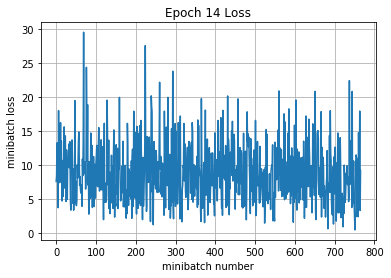

Iteration 10800: with minibatch training loss = 0.0908 and accuracy of 0.98
Iteration 10900: with minibatch training loss = 0.0859 and accuracy of 0.97
Iteration 11000: with minibatch training loss = 0.14 and accuracy of 0.94
Iteration 11100: with minibatch training loss = 0.09 and accuracy of 0.98
Iteration 11200: with minibatch training loss = 0.307 and accuracy of 0.91
Iteration 11300: with minibatch training loss = 0.0568 and accuracy of 0.98
Iteration 11400: with minibatch training loss = 0.0282 and accuracy of 0.98
Epoch 15, Overall loss = 0.125 and accuracy of 0.958


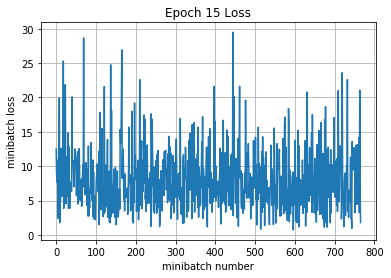

Iteration 11500: with minibatch training loss = 0.036 and accuracy of 0.98
Iteration 11600: with minibatch training loss = 0.0486 and accuracy of 0.98
Iteration 11700: with minibatch training loss = 0.154 and accuracy of 0.94
Iteration 11800: with minibatch training loss = 0.0967 and accuracy of 0.95
Iteration 11900: with minibatch training loss = 0.207 and accuracy of 0.92
Iteration 12000: with minibatch training loss = 0.0474 and accuracy of 0.98
Iteration 12100: with minibatch training loss = 0.172 and accuracy of 0.94
Iteration 12200: with minibatch training loss = 0.101 and accuracy of 0.95
Epoch 16, Overall loss = 0.105 and accuracy of 0.964


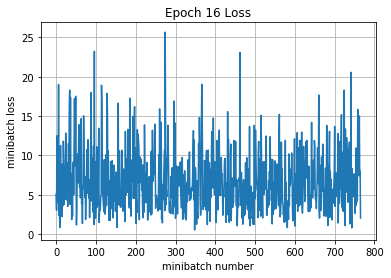

Iteration 12300: with minibatch training loss = 0.112 and accuracy of 0.98
Iteration 12400: with minibatch training loss = 0.0731 and accuracy of 0.98
Iteration 12500: with minibatch training loss = 0.00439 and accuracy of 1
Iteration 12600: with minibatch training loss = 0.0655 and accuracy of 0.98
Iteration 12700: with minibatch training loss = 0.237 and accuracy of 0.97
Iteration 12800: with minibatch training loss = 0.0842 and accuracy of 0.95
Iteration 12900: with minibatch training loss = 0.128 and accuracy of 0.95
Iteration 13000: with minibatch training loss = 0.0578 and accuracy of 0.98
Epoch 17, Overall loss = 0.1 and accuracy of 0.966


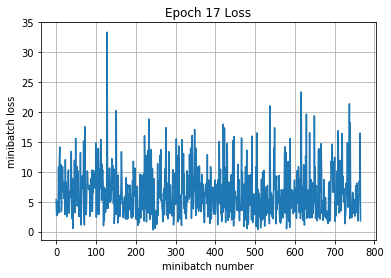

Iteration 13100: with minibatch training loss = 0.0546 and accuracy of 0.98
Iteration 13200: with minibatch training loss = 0.119 and accuracy of 0.97
Iteration 13300: with minibatch training loss = 0.0428 and accuracy of 0.98
Iteration 13400: with minibatch training loss = 0.0919 and accuracy of 0.95
Iteration 13500: with minibatch training loss = 0.0693 and accuracy of 0.97
Iteration 13600: with minibatch training loss = 0.0736 and accuracy of 0.97
Iteration 13700: with minibatch training loss = 0.138 and accuracy of 0.95
Epoch 18, Overall loss = 0.0855 and accuracy of 0.971


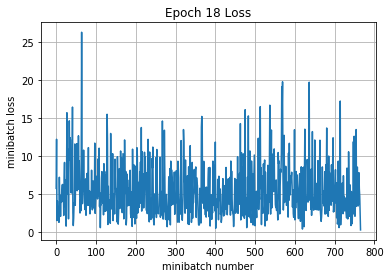

Iteration 13800: with minibatch training loss = 0.305 and accuracy of 0.97
Iteration 13900: with minibatch training loss = 0.038 and accuracy of 0.98
Iteration 14000: with minibatch training loss = 0.0759 and accuracy of 0.97
Iteration 14100: with minibatch training loss = 0.059 and accuracy of 0.97
Iteration 14200: with minibatch training loss = 0.058 and accuracy of 0.98
Iteration 14300: with minibatch training loss = 0.138 and accuracy of 0.94
Iteration 14400: with minibatch training loss = 0.062 and accuracy of 0.98
Iteration 14500: with minibatch training loss = 0.0143 and accuracy of 1
Epoch 19, Overall loss = 0.0881 and accuracy of 0.969


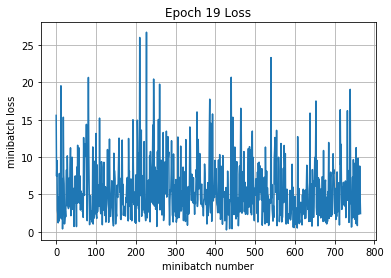

Iteration 14600: with minibatch training loss = 0.0727 and accuracy of 0.98
Iteration 14700: with minibatch training loss = 0.0332 and accuracy of 0.98
Iteration 14800: with minibatch training loss = 0.0161 and accuracy of 1
Iteration 14900: with minibatch training loss = 0.0148 and accuracy of 1
Iteration 15000: with minibatch training loss = 0.0295 and accuracy of 0.98
Iteration 15100: with minibatch training loss = 0.135 and accuracy of 0.97
Iteration 15200: with minibatch training loss = 0.0602 and accuracy of 0.97
Iteration 15300: with minibatch training loss = 0.0527 and accuracy of 0.97
Epoch 20, Overall loss = 0.0728 and accuracy of 0.975


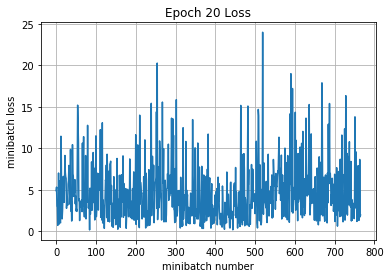

Iteration 15400: with minibatch training loss = 0.0938 and accuracy of 0.98
Iteration 15500: with minibatch training loss = 0.00638 and accuracy of 1
Iteration 15600: with minibatch training loss = 0.0398 and accuracy of 0.98
Iteration 15700: with minibatch training loss = 0.0419 and accuracy of 0.98
Iteration 15800: with minibatch training loss = 0.0546 and accuracy of 0.98
Iteration 15900: with minibatch training loss = 0.0182 and accuracy of 0.98
Iteration 16000: with minibatch training loss = 0.0735 and accuracy of 0.98
Epoch 21, Overall loss = 0.0697 and accuracy of 0.977


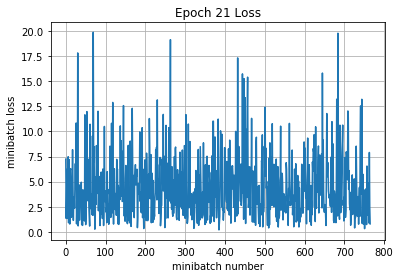

Iteration 16100: with minibatch training loss = 0.0519 and accuracy of 0.97
Iteration 16200: with minibatch training loss = 0.123 and accuracy of 0.97
Iteration 16300: with minibatch training loss = 0.0936 and accuracy of 0.97
Iteration 16400: with minibatch training loss = 0.0045 and accuracy of 1
Iteration 16500: with minibatch training loss = 0.0303 and accuracy of 1
Iteration 16600: with minibatch training loss = 0.012 and accuracy of 1
Iteration 16700: with minibatch training loss = 0.0245 and accuracy of 1
Iteration 16800: with minibatch training loss = 0.0273 and accuracy of 1
Epoch 22, Overall loss = 0.0652 and accuracy of 0.978


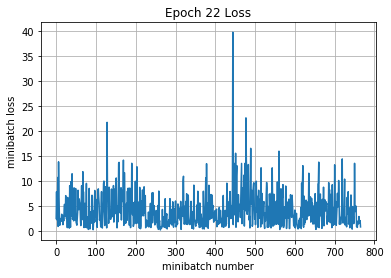

Iteration 16900: with minibatch training loss = 0.104 and accuracy of 0.97
Iteration 17000: with minibatch training loss = 0.0337 and accuracy of 1
Iteration 18400: with minibatch training loss = 0.0828 and accuracy of 0.97
Iteration 18500: with minibatch training loss = 0.0517 and accuracy of 0.97
Iteration 18600: with minibatch training loss = 0.0751 and accuracy of 0.98
Iteration 18700: with minibatch training loss = 0.0384 and accuracy of 0.98
Iteration 18800: with minibatch training loss = 0.101 and accuracy of 0.98
Iteration 18900: with minibatch training loss = 0.0144 and accuracy of 1
Iteration 19000: with minibatch training loss = 0.0845 and accuracy of 0.98
Iteration 19100: with minibatch training loss = 0.0196 and accuracy of 1
Epoch 25, Overall loss = 0.0553 and accuracy of 0.981


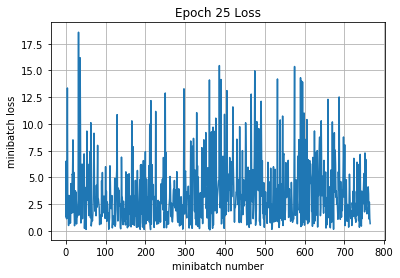

Iteration 19200: with minibatch training loss = 0.0077 and accuracy of 1
Iteration 19300: with minibatch training loss = 0.0103 and accuracy of 1
Iteration 19400: with minibatch training loss = 0.00705 and accuracy of 1
Iteration 19500: with minibatch training loss = 0.00616 and accuracy of 1
Iteration 19600: with minibatch training loss = 0.0224 and accuracy of 0.98
Iteration 19700: with minibatch training loss = 0.0381 and accuracy of 0.98
Iteration 19800: with minibatch training loss = 0.00297 and accuracy of 1
Iteration 19900: with minibatch training loss = 0.0267 and accuracy of 0.98
Epoch 26, Overall loss = 0.0507 and accuracy of 0.982


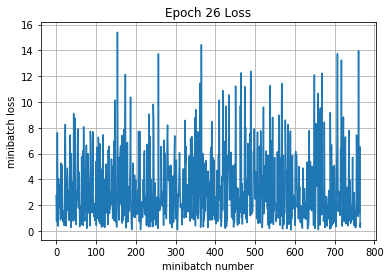

Iteration 20000: with minibatch training loss = 0.00211 and accuracy of 1
Iteration 20100: with minibatch training loss = 0.0544 and accuracy of 0.97
Iteration 20200: with minibatch training loss = 0.0796 and accuracy of 0.98
Iteration 20300: with minibatch training loss = 0.0427 and accuracy of 0.98
Iteration 20400: with minibatch training loss = 0.0572 and accuracy of 0.97
Iteration 20500: with minibatch training loss = 0.0717 and accuracy of 0.97
Iteration 20600: with minibatch training loss = 0.121 and accuracy of 0.95
Epoch 27, Overall loss = 0.0522 and accuracy of 0.983


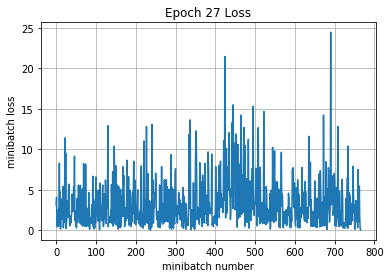

Iteration 20700: with minibatch training loss = 0.0295 and accuracy of 0.98
Iteration 20800: with minibatch training loss = 0.0918 and accuracy of 0.97
Iteration 20900: with minibatch training loss = 0.00592 and accuracy of 1
Iteration 21000: with minibatch training loss = 0.0101 and accuracy of 1
Iteration 21100: with minibatch training loss = 0.0164 and accuracy of 1
Iteration 21200: with minibatch training loss = 0.00428 and accuracy of 1
Iteration 21300: with minibatch training loss = 0.0121 and accuracy of 1
Iteration 21400: with minibatch training loss = 0.0175 and accuracy of 1
Epoch 28, Overall loss = 0.0538 and accuracy of 0.982


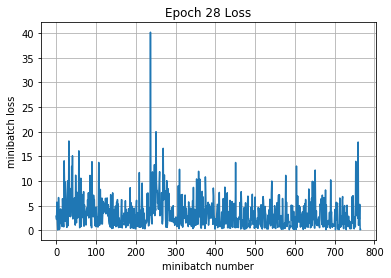

Iteration 21500: with minibatch training loss = 0.104 and accuracy of 0.95
Iteration 21600: with minibatch training loss = 0.0858 and accuracy of 0.97
Iteration 21700: with minibatch training loss = 0.0299 and accuracy of 0.98
Iteration 21800: with minibatch training loss = 0.117 and accuracy of 0.97
Iteration 21900: with minibatch training loss = 0.0538 and accuracy of 0.98
Iteration 22000: with minibatch training loss = 0.0257 and accuracy of 1
Iteration 22100: with minibatch training loss = 0.0125 and accuracy of 1
Iteration 22200: with minibatch training loss = 0.15 and accuracy of 0.98
Epoch 29, Overall loss = 0.0419 and accuracy of 0.986


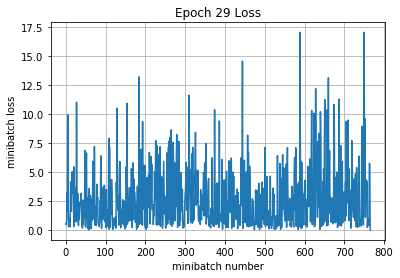

Iteration 22300: with minibatch training loss = 0.186 and accuracy of 0.95
Iteration 22400: with minibatch training loss = 0.0388 and accuracy of 0.98
Iteration 22500: with minibatch training loss = 0.00637 and accuracy of 1
Iteration 22600: with minibatch training loss = 0.0294 and accuracy of 1
Iteration 22700: with minibatch training loss = 0.169 and accuracy of 0.97
Iteration 22800: with minibatch training loss = 0.0564 and accuracy of 0.98
Iteration 22900: with minibatch training loss = 0.0232 and accuracy of 1
Epoch 30, Overall loss = 0.0402 and accuracy of 0.986


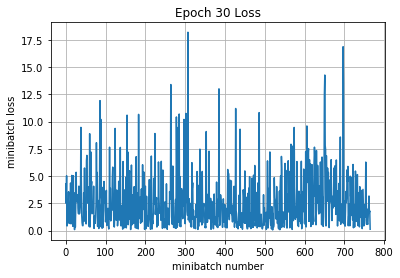

Iteration 23000: with minibatch training loss = 0.0172 and accuracy of 1
Iteration 23100: with minibatch training loss = 0.0939 and accuracy of 0.97
Iteration 23200: with minibatch training loss = 0.0594 and accuracy of 0.97
Iteration 23300: with minibatch training loss = 0.0524 and accuracy of 0.98
Iteration 23400: with minibatch training loss = 0.0118 and accuracy of 1
Iteration 23500: with minibatch training loss = 0.01 and accuracy of 1
Iteration 23600: with minibatch training loss = 0.021 and accuracy of 1
Iteration 23700: with minibatch training loss = 0.0202 and accuracy of 0.98
Epoch 31, Overall loss = 0.0437 and accuracy of 0.985


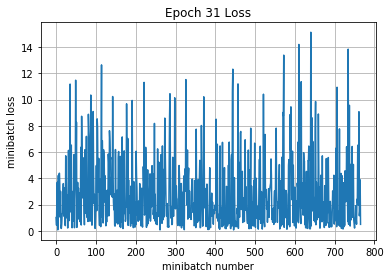

Iteration 23800: with minibatch training loss = 0.00643 and accuracy of 1
Iteration 23900: with minibatch training loss = 0.0334 and accuracy of 0.98
Iteration 24000: with minibatch training loss = 0.125 and accuracy of 0.95
Iteration 24100: with minibatch training loss = 0.0132 and accuracy of 1
Iteration 24200: with minibatch training loss = 0.0881 and accuracy of 0.97
Iteration 24300: with minibatch training loss = 0.0097 and accuracy of 1
Iteration 24400: with minibatch training loss = 0.027 and accuracy of 0.98
Iteration 24500: with minibatch training loss = 0.14 and accuracy of 0.95
Epoch 32, Overall loss = 0.0487 and accuracy of 0.984


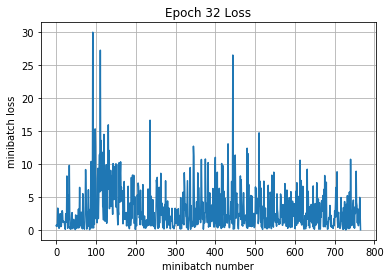

Iteration 24600: with minibatch training loss = 0.0698 and accuracy of 0.97
Iteration 24700: with minibatch training loss = 0.0203 and accuracy of 1
Iteration 24800: with minibatch training loss = 0.142 and accuracy of 0.97
Iteration 24900: with minibatch training loss = 0.00582 and accuracy of 1
Iteration 25000: with minibatch training loss = 0.0421 and accuracy of 0.98
Iteration 25100: with minibatch training loss = 0.00173 and accuracy of 1
Iteration 25200: with minibatch training loss = 0.00788 and accuracy of 1
Epoch 33, Overall loss = 0.0331 and accuracy of 0.989


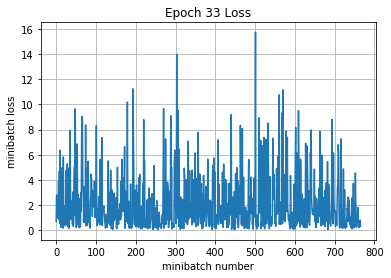

Iteration 25300: with minibatch training loss = 0.094 and accuracy of 0.95
Iteration 25400: with minibatch training loss = 0.0384 and accuracy of 0.98
Iteration 25500: with minibatch training loss = 0.0278 and accuracy of 0.98
Iteration 25600: with minibatch training loss = 0.12 and accuracy of 0.95
Iteration 25700: with minibatch training loss = 0.00646 and accuracy of 1
Iteration 25800: with minibatch training loss = 0.0449 and accuracy of 0.98
Iteration 25900: with minibatch training loss = 0.0608 and accuracy of 0.98
Iteration 26000: with minibatch training loss = 0.0051 and accuracy of 1
Epoch 34, Overall loss = 0.0342 and accuracy of 0.989


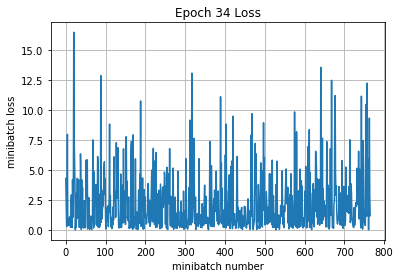

Iteration 26100: with minibatch training loss = 0.0384 and accuracy of 0.98
Iteration 26200: with minibatch training loss = 0.0259 and accuracy of 0.98
Iteration 26300: with minibatch training loss = 0.0629 and accuracy of 0.97
Iteration 26400: with minibatch training loss = 0.143 and accuracy of 0.95
Iteration 26500: with minibatch training loss = 0.0267 and accuracy of 0.98
Iteration 26600: with minibatch training loss = 0.00162 and accuracy of 1
Iteration 26700: with minibatch training loss = 0.15 and accuracy of 0.97
Iteration 26800: with minibatch training loss = 0.000891 and accuracy of 1
Epoch 35, Overall loss = 0.0403 and accuracy of 0.987


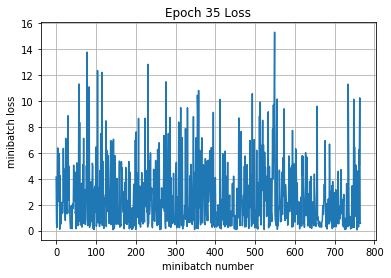

Iteration 26900: with minibatch training loss = 0.0014 and accuracy of 1
Iteration 27000: with minibatch training loss = 0.000529 and accuracy of 1
Iteration 27100: with minibatch training loss = 0.0887 and accuracy of 0.98
Iteration 27200: with minibatch training loss = 0.0474 and accuracy of 0.98
Iteration 27300: with minibatch training loss = 0.0285 and accuracy of 0.98
Iteration 27400: with minibatch training loss = 0.00691 and accuracy of 1
Iteration 27500: with minibatch training loss = 0.00569 and accuracy of 1
Epoch 36, Overall loss = 0.031 and accuracy of 0.989


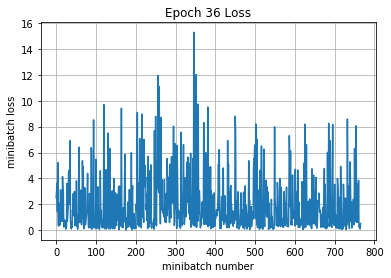

Iteration 27600: with minibatch training loss = 0.0581 and accuracy of 0.97
Iteration 27700: with minibatch training loss = 0.0178 and accuracy of 0.98
Iteration 27800: with minibatch training loss = 0.0107 and accuracy of 1
Iteration 27900: with minibatch training loss = 0.00993 and accuracy of 1
Iteration 28000: with minibatch training loss = 0.011 and accuracy of 1
Iteration 28100: with minibatch training loss = 0.009 and accuracy of 1
Iteration 28200: with minibatch training loss = 0.0179 and accuracy of 1
Iteration 28300: with minibatch training loss = 0.142 and accuracy of 0.95
Epoch 37, Overall loss = 0.0381 and accuracy of 0.988


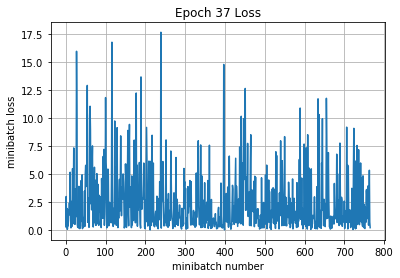

Iteration 28400: with minibatch training loss = 0.0162 and accuracy of 1
Iteration 28500: with minibatch training loss = 0.0118 and accuracy of 1
Iteration 28600: with minibatch training loss = 0.00792 and accuracy of 1
Iteration 28700: with minibatch training loss = 0.000658 and accuracy of 1
Iteration 28800: with minibatch training loss = 0.00203 and accuracy of 1
Iteration 28900: with minibatch training loss = 0.103 and accuracy of 0.95
Iteration 29000: with minibatch training loss = 0.00134 and accuracy of 1
Iteration 29100: with minibatch training loss = 0.0985 and accuracy of 0.97
Epoch 38, Overall loss = 0.0296 and accuracy of 0.99


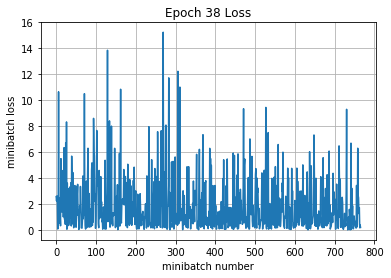

Iteration 29200: with minibatch training loss = 0.0107 and accuracy of 1
Iteration 29300: with minibatch training loss = 0.00444 and accuracy of 1
Iteration 29400: with minibatch training loss = 0.0617 and accuracy of 0.98
Iteration 29500: with minibatch training loss = 0.117 and accuracy of 0.95
Iteration 29600: with minibatch training loss = 0.145 and accuracy of 0.94
Iteration 29700: with minibatch training loss = 0.0219 and accuracy of 1
Iteration 29800: with minibatch training loss = 0.0041 and accuracy of 1
Epoch 39, Overall loss = 0.0464 and accuracy of 0.985


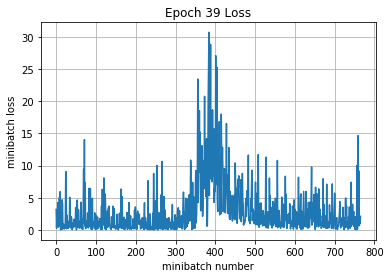

Iteration 29900: with minibatch training loss = 0.00483 and accuracy of 1
Iteration 30000: with minibatch training loss = 0.0026 and accuracy of 1
Iteration 30100: with minibatch training loss = 0.0102 and accuracy of 1
Iteration 30200: with minibatch training loss = 0.00623 and accuracy of 1
Iteration 30300: with minibatch training loss = 0.013 and accuracy of 1
Iteration 30400: with minibatch training loss = 0.00261 and accuracy of 1
Iteration 30500: with minibatch training loss = 0.0151 and accuracy of 1
Iteration 30600: with minibatch training loss = 0.0151 and accuracy of 0.98
Epoch 40, Overall loss = 0.0219 and accuracy of 0.993


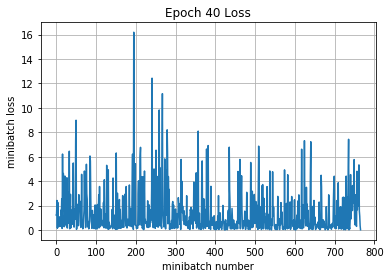

Iteration 30700: with minibatch training loss = 0.0102 and accuracy of 1
Iteration 30800: with minibatch training loss = 0.112 and accuracy of 0.98
Iteration 30900: with minibatch training loss = 0.0277 and accuracy of 1
Iteration 31000: with minibatch training loss = 0.0187 and accuracy of 0.98
Iteration 31100: with minibatch training loss = 0.00285 and accuracy of 1
Iteration 31200: with minibatch training loss = 0.0263 and accuracy of 0.98
Iteration 31300: with minibatch training loss = 0.025 and accuracy of 0.98
Iteration 31400: with minibatch training loss = 0.00816 and accuracy of 1
Epoch 41, Overall loss = 0.0283 and accuracy of 0.991


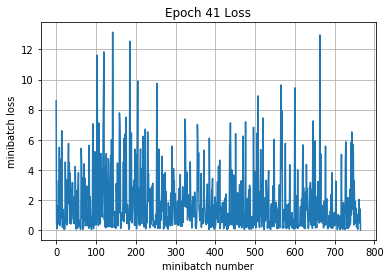

Iteration 31500: with minibatch training loss = 0.0292 and accuracy of 0.98
Iteration 31600: with minibatch training loss = 0.00833 and accuracy of 1
Iteration 31700: with minibatch training loss = 0.112 and accuracy of 0.97
Iteration 31800: with minibatch training loss = 0.00345 and accuracy of 1
Iteration 31900: with minibatch training loss = 0.00487 and accuracy of 1
Iteration 32000: with minibatch training loss = 0.0261 and accuracy of 0.98
Iteration 32100: with minibatch training loss = 0.0537 and accuracy of 0.97
Epoch 42, Overall loss = 0.0331 and accuracy of 0.989


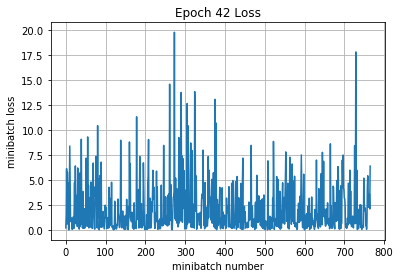

Iteration 32200: with minibatch training loss = 0.0483 and accuracy of 0.97
Iteration 32300: with minibatch training loss = 0.00685 and accuracy of 1
Iteration 32400: with minibatch training loss = 0.0482 and accuracy of 0.97
Iteration 32500: with minibatch training loss = 0.0223 and accuracy of 0.98
Iteration 32600: with minibatch training loss = 0.00936 and accuracy of 1
Iteration 32700: with minibatch training loss = 0.174 and accuracy of 0.98
Iteration 32800: with minibatch training loss = 0.0278 and accuracy of 0.98
Iteration 32900: with minibatch training loss = 0.00595 and accuracy of 1
Epoch 43, Overall loss = 0.0249 and accuracy of 0.992


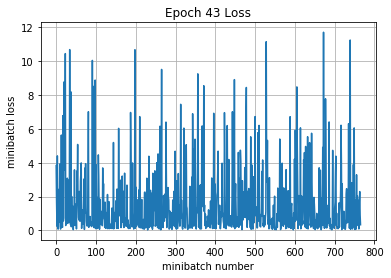

Iteration 33000: with minibatch training loss = 0.00549 and accuracy of 1
Iteration 33100: with minibatch training loss = 0.00162 and accuracy of 1
Iteration 33200: with minibatch training loss = 0.0364 and accuracy of 0.98
Iteration 33300: with minibatch training loss = 0.0238 and accuracy of 1
Iteration 33400: with minibatch training loss = 0.0547 and accuracy of 0.98
Iteration 33500: with minibatch training loss = 0.0438 and accuracy of 0.98
Iteration 33600: with minibatch training loss = 0.177 and accuracy of 0.95
Iteration 33700: with minibatch training loss = 0.0758 and accuracy of 0.98
Epoch 44, Overall loss = 0.0301 and accuracy of 0.99


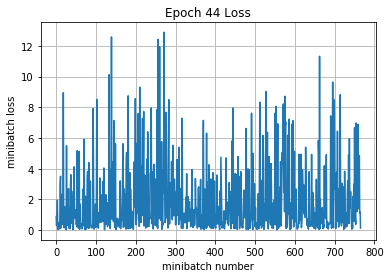

Iteration 33800: with minibatch training loss = 0.0784 and accuracy of 0.97
Iteration 33900: with minibatch training loss = 0.0438 and accuracy of 0.98
Iteration 34000: with minibatch training loss = 0.0566 and accuracy of 0.98
Iteration 34100: with minibatch training loss = 0.00264 and accuracy of 1
Iteration 34200: with minibatch training loss = 0.0104 and accuracy of 1
Iteration 34300: with minibatch training loss = 0.00265 and accuracy of 1
Iteration 34400: with minibatch training loss = 0.00751 and accuracy of 1
Epoch 45, Overall loss = 0.0267 and accuracy of 0.991


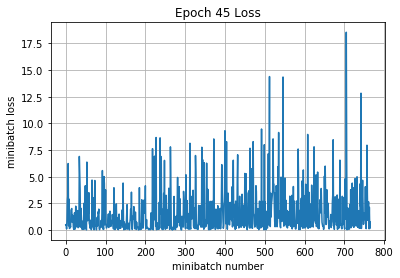

Iteration 34500: with minibatch training loss = 0.00273 and accuracy of 1
Iteration 34600: with minibatch training loss = 0.0553 and accuracy of 0.98
Iteration 34700: with minibatch training loss = 0.0271 and accuracy of 0.98
Iteration 34800: with minibatch training loss = 0.00145 and accuracy of 1
Iteration 34900: with minibatch training loss = 0.00315 and accuracy of 1
Iteration 35000: with minibatch training loss = 0.0204 and accuracy of 0.98
Iteration 35100: with minibatch training loss = 0.000679 and accuracy of 1
Iteration 35200: with minibatch training loss = 0.0177 and accuracy of 0.98
Epoch 46, Overall loss = 0.0244 and accuracy of 0.992


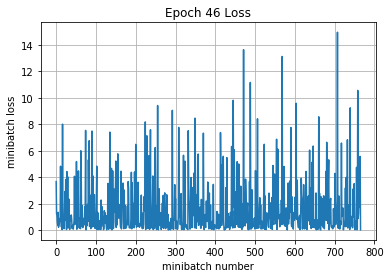

Iteration 35300: with minibatch training loss = 0.0146 and accuracy of 1
Iteration 35400: with minibatch training loss = 0.0653 and accuracy of 0.97
Iteration 35500: with minibatch training loss = 0.0202 and accuracy of 0.98
Iteration 35600: with minibatch training loss = 0.0172 and accuracy of 1
Iteration 35700: with minibatch training loss = 0.0118 and accuracy of 1
Iteration 35800: with minibatch training loss = 0.0619 and accuracy of 0.98
Iteration 35900: with minibatch training loss = 0.00201 and accuracy of 1
Iteration 37100: with minibatch training loss = 0.000185 and accuracy of 1
Iteration 37200: with minibatch training loss = 0.0119 and accuracy of 1
Iteration 37300: with minibatch training loss = 0.0364 and accuracy of 0.98
Iteration 37400: with minibatch training loss = 0.079 and accuracy of 0.97
Iteration 37500: with minibatch training loss = 0.05 and accuracy of 0.97
Epoch 49, Overall loss = 0.0212 and accuracy of 0.993


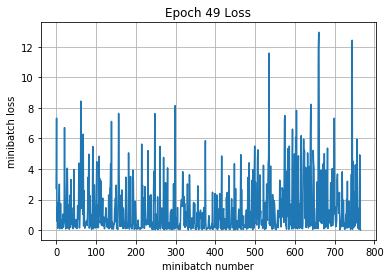

Iteration 37600: with minibatch training loss = 0.00229 and accuracy of 1
Iteration 37700: with minibatch training loss = 0.00929 and accuracy of 1
Iteration 37800: with minibatch training loss = 0.0963 and accuracy of 0.97
Iteration 37900: with minibatch training loss = 0.00681 and accuracy of 1
Iteration 38000: with minibatch training loss = 0.0868 and accuracy of 0.98
Iteration 38100: with minibatch training loss = 0.00176 and accuracy of 1
Iteration 38200: with minibatch training loss = 0.0496 and accuracy of 0.98
Epoch 50, Overall loss = 0.0267 and accuracy of 0.991


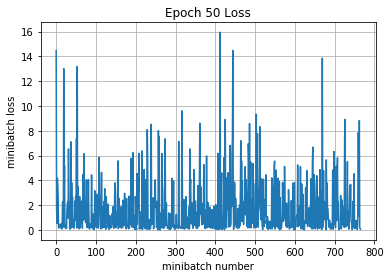

Iteration 38300: with minibatch training loss = 0.00221 and accuracy of 1
Iteration 38400: with minibatch training loss = 0.127 and accuracy of 0.94
Iteration 38500: with minibatch training loss = 0.0308 and accuracy of 0.98
Iteration 38600: with minibatch training loss = 0.03 and accuracy of 0.98
Iteration 38700: with minibatch training loss = 0.0564 and accuracy of 0.97
Iteration 38800: with minibatch training loss = 0.00515 and accuracy of 1
Iteration 38900: with minibatch training loss = 6.76e-05 and accuracy of 1
Iteration 39000: with minibatch training loss = 0.0215 and accuracy of 1
Epoch 51, Overall loss = 0.0221 and accuracy of 0.993


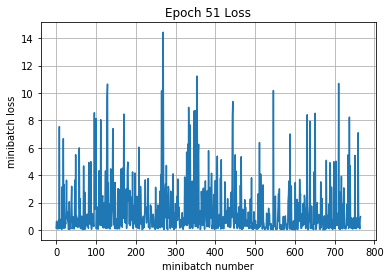

Iteration 39100: with minibatch training loss = 0.000329 and accuracy of 1
Iteration 39200: with minibatch training loss = 0.00251 and accuracy of 1
Iteration 39300: with minibatch training loss = 0.0351 and accuracy of 0.98
Iteration 39400: with minibatch training loss = 0.00465 and accuracy of 1
Iteration 39500: with minibatch training loss = 0.0282 and accuracy of 0.98
Iteration 39600: with minibatch training loss = 0.000735 and accuracy of 1
Iteration 39700: with minibatch training loss = 0.0112 and accuracy of 1
Iteration 39800: with minibatch training loss = 0.0394 and accuracy of 0.98
Epoch 52, Overall loss = 0.0225 and accuracy of 0.993


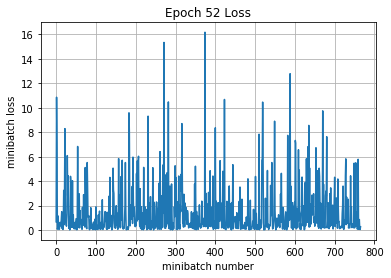

Iteration 39900: with minibatch training loss = 0.0011 and accuracy of 1
Iteration 40000: with minibatch training loss = 0.00556 and accuracy of 1
Iteration 40100: with minibatch training loss = 0.0587 and accuracy of 0.97
Iteration 40200: with minibatch training loss = 0.000567 and accuracy of 1
Iteration 40300: with minibatch training loss = 0.0215 and accuracy of 1
Iteration 40400: with minibatch training loss = 0.011 and accuracy of 1
Iteration 40500: with minibatch training loss = 0.0278 and accuracy of 0.98
Epoch 53, Overall loss = 0.0211 and accuracy of 0.993


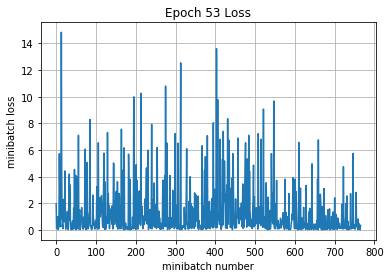

Iteration 40600: with minibatch training loss = 0.0492 and accuracy of 0.98
Iteration 40700: with minibatch training loss = 0.00988 and accuracy of 1
Iteration 40800: with minibatch training loss = 0.0533 and accuracy of 0.98
Iteration 40900: with minibatch training loss = 0.00346 and accuracy of 1
Iteration 41000: with minibatch training loss = 0.121 and accuracy of 0.95
Iteration 41100: with minibatch training loss = 0.00169 and accuracy of 1
Iteration 41200: with minibatch training loss = 0.000615 and accuracy of 1
Iteration 41300: with minibatch training loss = 0.0159 and accuracy of 0.98
Epoch 54, Overall loss = 0.0182 and accuracy of 0.994


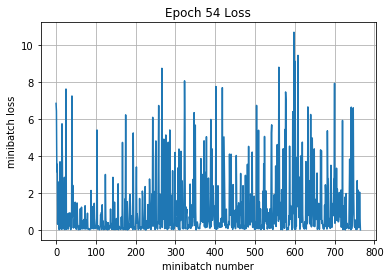

Iteration 41400: with minibatch training loss = 0.0249 and accuracy of 0.98
Iteration 41500: with minibatch training loss = 0.0327 and accuracy of 0.98
Iteration 41600: with minibatch training loss = 0.026 and accuracy of 0.98
Iteration 41700: with minibatch training loss = 0.00741 and accuracy of 1
Iteration 41800: with minibatch training loss = 0.0141 and accuracy of 1
Iteration 41900: with minibatch training loss = 0.00816 and accuracy of 1
Iteration 42000: with minibatch training loss = 0.0286 and accuracy of 0.98
Iteration 42100: with minibatch training loss = 0.0039 and accuracy of 1
Epoch 55, Overall loss = 0.028 and accuracy of 0.991


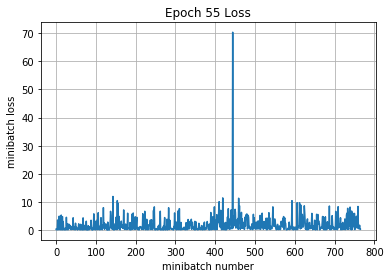

Iteration 42200: with minibatch training loss = 0.0434 and accuracy of 0.95
Iteration 42300: with minibatch training loss = 0.00102 and accuracy of 1
Iteration 42400: with minibatch training loss = 0.0337 and accuracy of 0.98
Iteration 42500: with minibatch training loss = 0.00206 and accuracy of 1
Iteration 42600: with minibatch training loss = 0.00104 and accuracy of 1
Iteration 42700: with minibatch training loss = 0.00194 and accuracy of 1
Iteration 42800: with minibatch training loss = 0.0415 and accuracy of 0.98
Epoch 56, Overall loss = 0.0196 and accuracy of 0.994


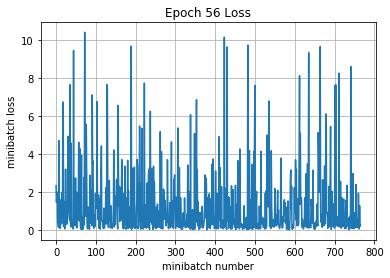

Iteration 42900: with minibatch training loss = 0.00454 and accuracy of 1
Iteration 43000: with minibatch training loss = 0.0515 and accuracy of 0.98
Iteration 43100: with minibatch training loss = 0.0032 and accuracy of 1
Iteration 43200: with minibatch training loss = 0.0825 and accuracy of 0.98
Iteration 43300: with minibatch training loss = 0.0027 and accuracy of 1
Iteration 43400: with minibatch training loss = 0.0225 and accuracy of 0.98
Iteration 43500: with minibatch training loss = 0.00165 and accuracy of 1
Iteration 43600: with minibatch training loss = 0.0716 and accuracy of 0.98
Epoch 57, Overall loss = 0.0191 and accuracy of 0.994


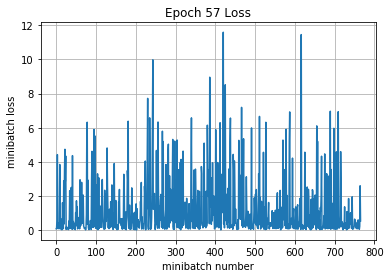

Iteration 43700: with minibatch training loss = 0.000986 and accuracy of 1
Iteration 43800: with minibatch training loss = 0.0299 and accuracy of 0.98
Iteration 43900: with minibatch training loss = 0.0306 and accuracy of 0.98
Iteration 44000: with minibatch training loss = 0.0294 and accuracy of 0.98
Iteration 44100: with minibatch training loss = 0.0563 and accuracy of 0.98
Iteration 44200: with minibatch training loss = 0.00164 and accuracy of 1
Iteration 44300: with minibatch training loss = 0.00374 and accuracy of 1
Iteration 44400: with minibatch training loss = 0.00885 and accuracy of 1
Epoch 58, Overall loss = 0.0193 and accuracy of 0.994


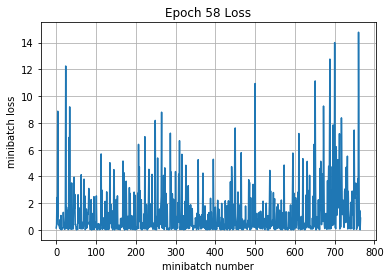

Iteration 44500: with minibatch training loss = 0.00414 and accuracy of 1
Iteration 44600: with minibatch training loss = 0.0284 and accuracy of 0.98
Iteration 44700: with minibatch training loss = 0.00236 and accuracy of 1
Iteration 44800: with minibatch training loss = 0.0114 and accuracy of 1
Iteration 44900: with minibatch training loss = 0.0661 and accuracy of 0.97
Iteration 45000: with minibatch training loss = 0.00834 and accuracy of 1
Iteration 45100: with minibatch training loss = 0.00112 and accuracy of 1
Epoch 59, Overall loss = 0.0197 and accuracy of 0.993


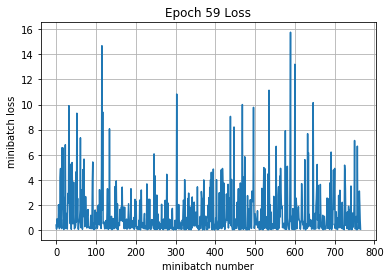

Iteration 45200: with minibatch training loss = 0.0907 and accuracy of 0.95
Iteration 45300: with minibatch training loss = 0.0198 and accuracy of 1
Iteration 45400: with minibatch training loss = 0.0128 and accuracy of 1
Iteration 45500: with minibatch training loss = 0.0137 and accuracy of 0.98
Iteration 45600: with minibatch training loss = 0.000355 and accuracy of 1
Iteration 45700: with minibatch training loss = 0.00296 and accuracy of 1
Iteration 45800: with minibatch training loss = 0.00442 and accuracy of 1
Iteration 45900: with minibatch training loss = 0.000557 and accuracy of 1
Epoch 60, Overall loss = 0.0205 and accuracy of 0.994


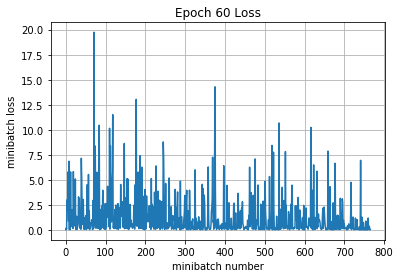

Iteration 46000: with minibatch training loss = 0.000663 and accuracy of 1
Iteration 46100: with minibatch training loss = 0.000423 and accuracy of 1
Iteration 46200: with minibatch training loss = 0.00358 and accuracy of 1
Iteration 46300: with minibatch training loss = 0.00518 and accuracy of 1
Iteration 46400: with minibatch training loss = 0.0185 and accuracy of 0.98
Iteration 46500: with minibatch training loss = 0.000761 and accuracy of 1
Iteration 46600: with minibatch training loss = 0.023 and accuracy of 0.98
Iteration 46700: with minibatch training loss = 0.000378 and accuracy of 1
Epoch 61, Overall loss = 0.0145 and accuracy of 0.995


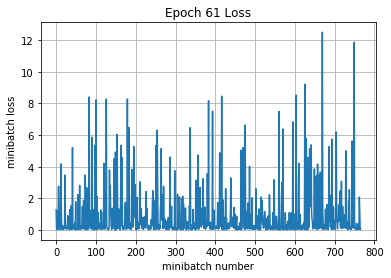

Iteration 46800: with minibatch training loss = 0.0676 and accuracy of 0.98
Iteration 46900: with minibatch training loss = 0.00307 and accuracy of 1
Iteration 47000: with minibatch training loss = 0.0536 and accuracy of 0.98
Iteration 47100: with minibatch training loss = 0.00162 and accuracy of 1
Iteration 47200: with minibatch training loss = 0.0189 and accuracy of 1
Iteration 47300: with minibatch training loss = 0.0858 and accuracy of 0.97
Iteration 47400: with minibatch training loss = 0.00166 and accuracy of 1
Epoch 62, Overall loss = 0.0185 and accuracy of 0.994


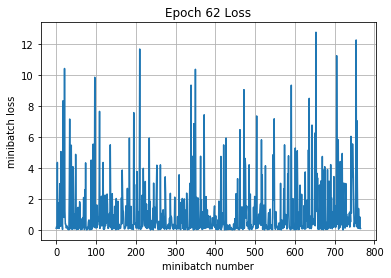

Iteration 47500: with minibatch training loss = 0.000667 and accuracy of 1
Iteration 47600: with minibatch training loss = 0.00129 and accuracy of 1
Iteration 47700: with minibatch training loss = 0.00542 and accuracy of 1
Iteration 47800: with minibatch training loss = 0.00101 and accuracy of 1
Iteration 47900: with minibatch training loss = 0.0431 and accuracy of 0.98
Iteration 48000: with minibatch training loss = 0.00467 and accuracy of 1
Iteration 48100: with minibatch training loss = 0.00496 and accuracy of 1
Iteration 48200: with minibatch training loss = 0.0251 and accuracy of 1
Epoch 63, Overall loss = 0.0195 and accuracy of 0.993


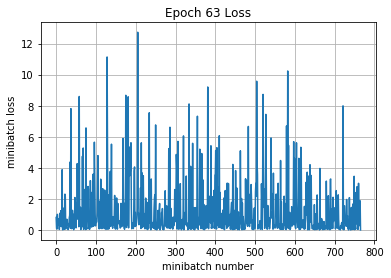

Iteration 48300: with minibatch training loss = 0.0159 and accuracy of 0.98
Iteration 48400: with minibatch training loss = 0.00364 and accuracy of 1
Iteration 48500: with minibatch training loss = 0.0066 and accuracy of 1
Iteration 48600: with minibatch training loss = 0.0331 and accuracy of 0.98
Iteration 48700: with minibatch training loss = 0.036 and accuracy of 0.98
Iteration 48800: with minibatch training loss = 0.0157 and accuracy of 0.98
Iteration 48900: with minibatch training loss = 0.0472 and accuracy of 0.97
Iteration 49000: with minibatch training loss = 0.00227 and accuracy of 1
Epoch 64, Overall loss = 0.0167 and accuracy of 0.995


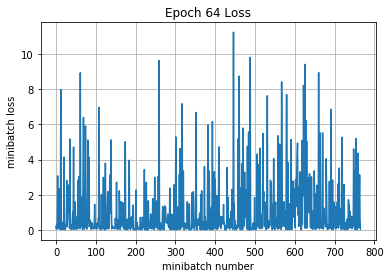

Iteration 49100: with minibatch training loss = 0.0879 and accuracy of 0.98
Iteration 49200: with minibatch training loss = 0.00105 and accuracy of 1
Iteration 49300: with minibatch training loss = 0.00655 and accuracy of 1
Iteration 49400: with minibatch training loss = 0.000598 and accuracy of 1
Iteration 49500: with minibatch training loss = 0.000122 and accuracy of 1
Iteration 49600: with minibatch training loss = 0.00939 and accuracy of 1
Iteration 49700: with minibatch training loss = 0.00253 and accuracy of 1
Epoch 65, Overall loss = 0.0165 and accuracy of 0.994


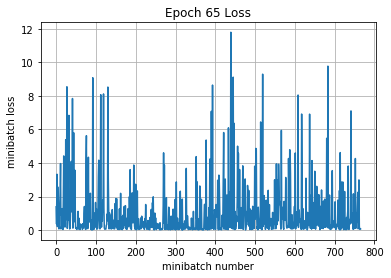

Iteration 49800: with minibatch training loss = 0.00416 and accuracy of 1
Iteration 49900: with minibatch training loss = 0.0451 and accuracy of 0.97
Iteration 50000: with minibatch training loss = 0.00757 and accuracy of 1
Iteration 50100: with minibatch training loss = 0.0137 and accuracy of 1
Iteration 50200: with minibatch training loss = 0.00556 and accuracy of 1
Iteration 50300: with minibatch training loss = 0.00244 and accuracy of 1
Iteration 50400: with minibatch training loss = 0.00242 and accuracy of 1
Iteration 50500: with minibatch training loss = 0.0106 and accuracy of 1
Epoch 66, Overall loss = 0.0186 and accuracy of 0.994


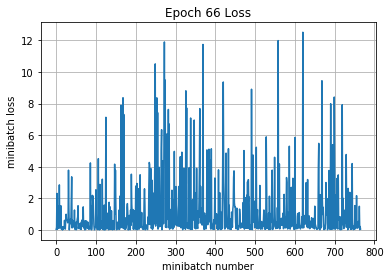

Iteration 50600: with minibatch training loss = 0.000621 and accuracy of 1
Iteration 50700: with minibatch training loss = 0.0123 and accuracy of 1
Iteration 50800: with minibatch training loss = 0.0157 and accuracy of 0.98
Iteration 50900: with minibatch training loss = 0.0369 and accuracy of 0.98
Iteration 51000: with minibatch training loss = 0.00168 and accuracy of 1
Iteration 51100: with minibatch training loss = 0.002 and accuracy of 1
Iteration 51200: with minibatch training loss = 0.001 and accuracy of 1
Iteration 51300: with minibatch training loss = 0.00051 and accuracy of 1
Epoch 67, Overall loss = 0.0142 and accuracy of 0.995


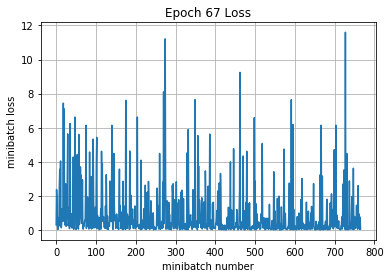

Iteration 51400: with minibatch training loss = 0.00753 and accuracy of 1
Iteration 51500: with minibatch training loss = 0.0265 and accuracy of 0.98
Iteration 51600: with minibatch training loss = 0.000803 and accuracy of 1
Iteration 51700: with minibatch training loss = 0.157 and accuracy of 0.95
Iteration 51800: with minibatch training loss = 0.0157 and accuracy of 1
Iteration 51900: with minibatch training loss = 0.00744 and accuracy of 1
Iteration 52000: with minibatch training loss = 0.0017 and accuracy of 1
Epoch 68, Overall loss = 0.0163 and accuracy of 0.995


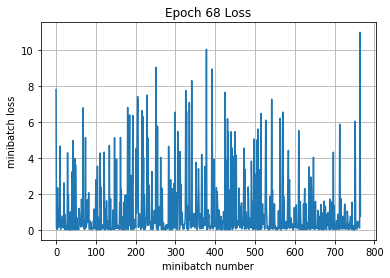

Iteration 52100: with minibatch training loss = 0.00296 and accuracy of 1
Iteration 52200: with minibatch training loss = 0.000553 and accuracy of 1
Iteration 52300: with minibatch training loss = 0.00167 and accuracy of 1
Iteration 52400: with minibatch training loss = 0.0582 and accuracy of 0.98
Iteration 52500: with minibatch training loss = 0.0322 and accuracy of 0.98
Iteration 52600: with minibatch training loss = 0.00209 and accuracy of 1
Iteration 52700: with minibatch training loss = 0.00931 and accuracy of 1
Iteration 52800: with minibatch training loss = 0.00123 and accuracy of 1
Epoch 69, Overall loss = 0.0164 and accuracy of 0.995


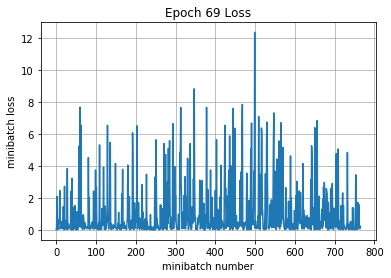

Iteration 52900: with minibatch training loss = 0.000988 and accuracy of 1
Iteration 53000: with minibatch training loss = 0.0081 and accuracy of 1
Iteration 53100: with minibatch training loss = 0.0123 and accuracy of 0.98
Iteration 53200: with minibatch training loss = 0.000657 and accuracy of 1
Iteration 53300: with minibatch training loss = 0.0297 and accuracy of 0.98
Iteration 53400: with minibatch training loss = 0.00691 and accuracy of 1
Iteration 53500: with minibatch training loss = 0.00226 and accuracy of 1
Iteration 53600: with minibatch training loss = 0.0177 and accuracy of 0.98
Epoch 70, Overall loss = 0.0144 and accuracy of 0.995


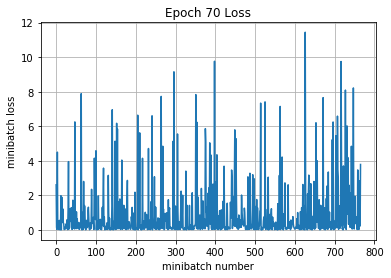

Iteration 53700: with minibatch training loss = 0.00599 and accuracy of 1
Iteration 53800: with minibatch training loss = 0.00137 and accuracy of 1
Iteration 53900: with minibatch training loss = 0.0176 and accuracy of 0.98
Iteration 54000: with minibatch training loss = 0.00366 and accuracy of 1
Iteration 54100: with minibatch training loss = 0.00164 and accuracy of 1
Iteration 54200: with minibatch training loss = 0.00609 and accuracy of 1
Iteration 54300: with minibatch training loss = 0.0275 and accuracy of 1
Epoch 71, Overall loss = 0.0182 and accuracy of 0.994


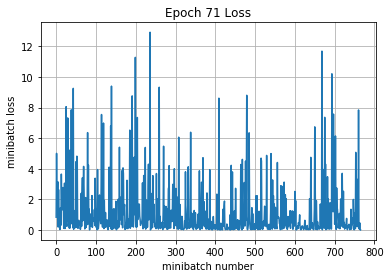

Iteration 54400: with minibatch training loss = 0.0331 and accuracy of 0.98
Iteration 54500: with minibatch training loss = 0.00207 and accuracy of 1
Iteration 54600: with minibatch training loss = 0.00181 and accuracy of 1
Iteration 54700: with minibatch training loss = 0.0176 and accuracy of 0.98
Iteration 54800: with minibatch training loss = 0.000478 and accuracy of 1
Iteration 54900: with minibatch training loss = 0.00255 and accuracy of 1
Iteration 55000: with minibatch training loss = 0.00915 and accuracy of 1
Iteration 55100: with minibatch training loss = 0.00154 and accuracy of 1
Epoch 72, Overall loss = 0.0129 and accuracy of 0.996


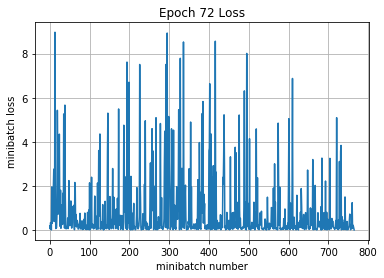

Iteration 55200: with minibatch training loss = 0.00103 and accuracy of 1
Iteration 55300: with minibatch training loss = 0.108 and accuracy of 0.97
Iteration 55400: with minibatch training loss = 0.000988 and accuracy of 1
Iteration 55500: with minibatch training loss = 0.00913 and accuracy of 1
Iteration 55600: with minibatch training loss = 0.00134 and accuracy of 1
Iteration 55700: with minibatch training loss = 0.00302 and accuracy of 1
Iteration 55800: with minibatch training loss = 0.000806 and accuracy of 1
Iteration 55900: with minibatch training loss = 0.00751 and accuracy of 1
Epoch 73, Overall loss = 0.0138 and accuracy of 0.996


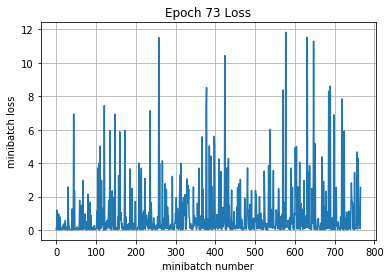

Iteration 56000: with minibatch training loss = 0.0177 and accuracy of 0.98
Iteration 56100: with minibatch training loss = 0.0161 and accuracy of 1
Iteration 56200: with minibatch training loss = 0.0135 and accuracy of 1
Iteration 56300: with minibatch training loss = 0.00767 and accuracy of 1
Iteration 56400: with minibatch training loss = 0.0022 and accuracy of 1
Iteration 56500: with minibatch training loss = 0.00209 and accuracy of 1
Iteration 56600: with minibatch training loss = 0.00354 and accuracy of 1
Epoch 74, Overall loss = 0.0138 and accuracy of 0.995


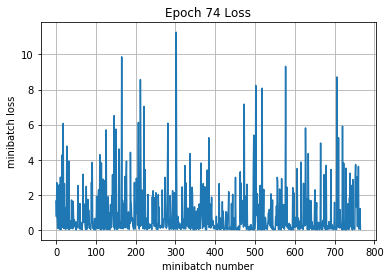

Iteration 56700: with minibatch training loss = 0.000484 and accuracy of 1
Iteration 56800: with minibatch training loss = 0.00204 and accuracy of 1
Iteration 56900: with minibatch training loss = 0.0227 and accuracy of 0.98
Iteration 57000: with minibatch training loss = 0.00564 and accuracy of 1
Iteration 57100: with minibatch training loss = 0.00243 and accuracy of 1
Iteration 57200: with minibatch training loss = 0.000292 and accuracy of 1
Iteration 57300: with minibatch training loss = 0.00901 and accuracy of 1
Iteration 57400: with minibatch training loss = 0.00412 and accuracy of 1
Epoch 75, Overall loss = 0.0248 and accuracy of 0.992


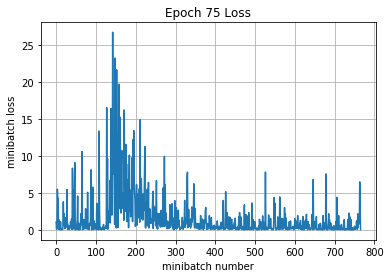

Iteration 57500: with minibatch training loss = 0.000509 and accuracy of 1
Iteration 57600: with minibatch training loss = 0.000785 and accuracy of 1
Iteration 57700: with minibatch training loss = 0.000329 and accuracy of 1
Iteration 57800: with minibatch training loss = 0.0027 and accuracy of 1
Iteration 57900: with minibatch training loss = 0.0146 and accuracy of 1
Iteration 58000: with minibatch training loss = 0.0146 and accuracy of 1
Iteration 58100: with minibatch training loss = 0.00296 and accuracy of 1
Iteration 58200: with minibatch training loss = 0.000482 and accuracy of 1
Epoch 76, Overall loss = 0.00801 and accuracy of 0.998


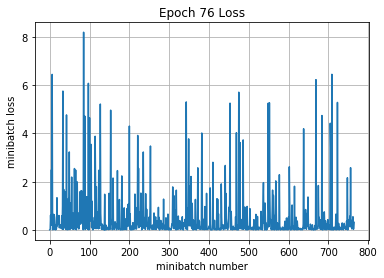

Iteration 58300: with minibatch training loss = 0.00683 and accuracy of 1
Iteration 58400: with minibatch training loss = 7.17e-05 and accuracy of 1
Iteration 58500: with minibatch training loss = 0.00212 and accuracy of 1
Iteration 58600: with minibatch training loss = 0.000855 and accuracy of 1
Iteration 58700: with minibatch training loss = 0.0165 and accuracy of 1
Iteration 58800: with minibatch training loss = 0.000263 and accuracy of 1
Iteration 58900: with minibatch training loss = 0.00274 and accuracy of 1
Epoch 77, Overall loss = 0.0137 and accuracy of 0.995


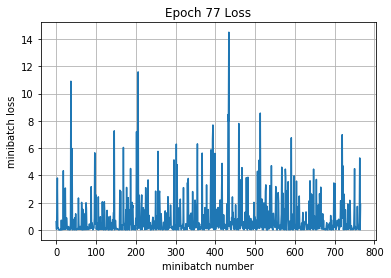

Iteration 59000: with minibatch training loss = 0.00306 and accuracy of 1
Iteration 59100: with minibatch training loss = 0.0073 and accuracy of 1
Iteration 59200: with minibatch training loss = 0.0451 and accuracy of 0.98
Iteration 59300: with minibatch training loss = 0.00207 and accuracy of 1
Iteration 59400: with minibatch training loss = 0.00198 and accuracy of 1
Iteration 59500: with minibatch training loss = 0.000651 and accuracy of 1
Iteration 59600: with minibatch training loss = 0.00836 and accuracy of 1
Iteration 59700: with minibatch training loss = 0.0232 and accuracy of 1
Epoch 78, Overall loss = 0.0143 and accuracy of 0.995


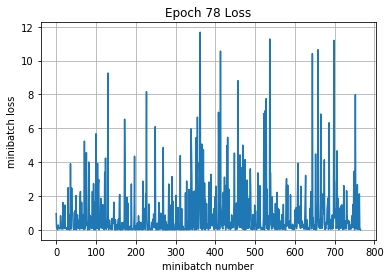

Iteration 59800: with minibatch training loss = 0.000565 and accuracy of 1
Iteration 59900: with minibatch training loss = 0.0356 and accuracy of 0.98
Iteration 60000: with minibatch training loss = 0.000522 and accuracy of 1
Iteration 60100: with minibatch training loss = 0.0224 and accuracy of 0.98
Iteration 60200: with minibatch training loss = 0.000494 and accuracy of 1
Iteration 60300: with minibatch training loss = 0.000496 and accuracy of 1
Iteration 60400: with minibatch training loss = 0.00158 and accuracy of 1
Iteration 60500: with minibatch training loss = 0.00508 and accuracy of 1
Epoch 79, Overall loss = 0.0129 and accuracy of 0.996


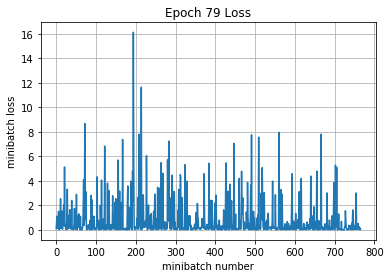

Iteration 60600: with minibatch training loss = 0.000587 and accuracy of 1
Iteration 60700: with minibatch training loss = 0.000438 and accuracy of 1
Iteration 60800: with minibatch training loss = 0.000539 and accuracy of 1
Iteration 60900: with minibatch training loss = 0.000277 and accuracy of 1
Iteration 61000: with minibatch training loss = 0.00054 and accuracy of 1
Iteration 61100: with minibatch training loss = 0.00947 and accuracy of 1
Iteration 61200: with minibatch training loss = 0.00392 and accuracy of 1
Epoch 80, Overall loss = 0.0122 and accuracy of 0.996


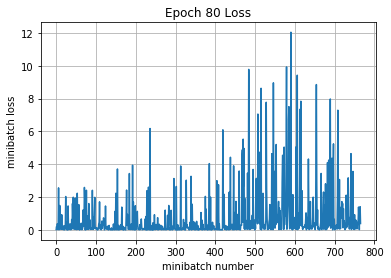

Iteration 61300: with minibatch training loss = 0.053 and accuracy of 0.97
Iteration 61400: with minibatch training loss = 0.0234 and accuracy of 0.98
Iteration 61500: with minibatch training loss = 0.00389 and accuracy of 1
Iteration 61600: with minibatch training loss = 0.00205 and accuracy of 1
Iteration 61700: with minibatch training loss = 0.00166 and accuracy of 1
Iteration 61800: with minibatch training loss = 0.00757 and accuracy of 1
Iteration 61900: with minibatch training loss = 0.000265 and accuracy of 1
Iteration 62000: with minibatch training loss = 0.00166 and accuracy of 1
Epoch 81, Overall loss = 0.0134 and accuracy of 0.996


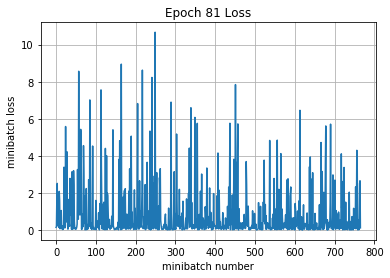

Iteration 62100: with minibatch training loss = 0.00177 and accuracy of 1
Iteration 62200: with minibatch training loss = 0.00159 and accuracy of 1
Iteration 62300: with minibatch training loss = 0.001 and accuracy of 1
Iteration 62400: with minibatch training loss = 0.0128 and accuracy of 1
Iteration 62500: with minibatch training loss = 0.0161 and accuracy of 0.98
Iteration 62600: with minibatch training loss = 0.0147 and accuracy of 0.98
Iteration 62700: with minibatch training loss = 0.00527 and accuracy of 1
Iteration 62800: with minibatch training loss = 0.0509 and accuracy of 0.98
Epoch 82, Overall loss = 0.0124 and accuracy of 0.996


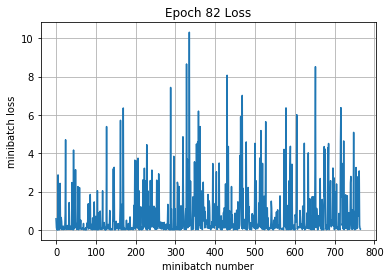

Iteration 62900: with minibatch training loss = 0.000266 and accuracy of 1
Iteration 63000: with minibatch training loss = 0.000984 and accuracy of 1
Iteration 63100: with minibatch training loss = 0.0133 and accuracy of 1
Iteration 63200: with minibatch training loss = 0.000964 and accuracy of 1
Iteration 63300: with minibatch training loss = 0.00953 and accuracy of 1
Iteration 63400: with minibatch training loss = 0.000521 and accuracy of 1
Iteration 63500: with minibatch training loss = 0.00138 and accuracy of 1
Epoch 83, Overall loss = 0.0106 and accuracy of 0.997


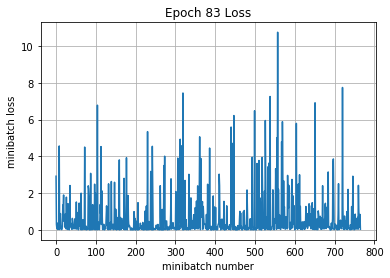

Iteration 63600: with minibatch training loss = 0.00283 and accuracy of 1
Iteration 63700: with minibatch training loss = 0.0002 and accuracy of 1
Iteration 63800: with minibatch training loss = 0.00821 and accuracy of 1
Iteration 63900: with minibatch training loss = 0.00973 and accuracy of 1
Iteration 64000: with minibatch training loss = 0.0348 and accuracy of 0.98
Iteration 64100: with minibatch training loss = 0.00231 and accuracy of 1
Iteration 64200: with minibatch training loss = 0.0108 and accuracy of 1
Iteration 64300: with minibatch training loss = 0.174 and accuracy of 0.97
Epoch 84, Overall loss = 0.0126 and accuracy of 0.996


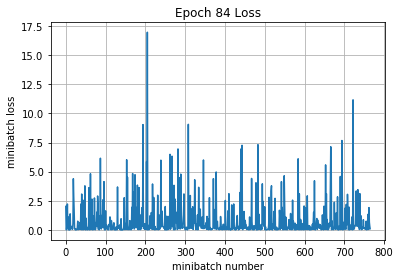

Iteration 64400: with minibatch training loss = 0.0162 and accuracy of 1
Iteration 64500: with minibatch training loss = 0.037 and accuracy of 0.98
Iteration 64600: with minibatch training loss = 0.00196 and accuracy of 1
Iteration 64700: with minibatch training loss = 0.00132 and accuracy of 1
Iteration 64800: with minibatch training loss = 0.005 and accuracy of 1
Iteration 64900: with minibatch training loss = 0.0233 and accuracy of 0.98
Iteration 65000: with minibatch training loss = 0.0324 and accuracy of 0.98
Iteration 65100: with minibatch training loss = 0.00091 and accuracy of 1
Epoch 85, Overall loss = 0.0139 and accuracy of 0.995


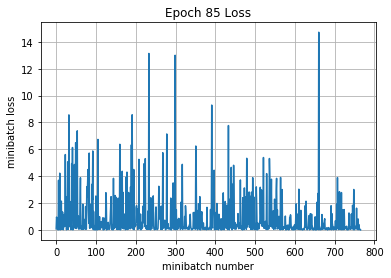

Iteration 65200: with minibatch training loss = 0.0027 and accuracy of 1
Iteration 65300: with minibatch training loss = 0.164 and accuracy of 0.98
Iteration 65400: with minibatch training loss = 0.00602 and accuracy of 1
Iteration 65500: with minibatch training loss = 0.000394 and accuracy of 1
Iteration 65600: with minibatch training loss = 0.00159 and accuracy of 1
Iteration 65700: with minibatch training loss = 0.00788 and accuracy of 1
Iteration 65800: with minibatch training loss = 0.00203 and accuracy of 1
Epoch 86, Overall loss = 0.0146 and accuracy of 0.995


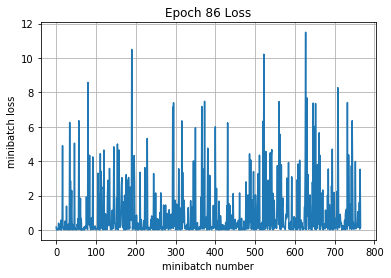

Iteration 65900: with minibatch training loss = 0.000517 and accuracy of 1
Iteration 66000: with minibatch training loss = 0.00964 and accuracy of 1
Iteration 66100: with minibatch training loss = 0.00322 and accuracy of 1
Iteration 66200: with minibatch training loss = 0.000389 and accuracy of 1
Iteration 66300: with minibatch training loss = 0.0141 and accuracy of 0.98
Iteration 66400: with minibatch training loss = 0.00162 and accuracy of 1
Iteration 66500: with minibatch training loss = 0.000255 and accuracy of 1
Iteration 66600: with minibatch training loss = 0.00603 and accuracy of 1
Epoch 87, Overall loss = 0.00854 and accuracy of 0.997


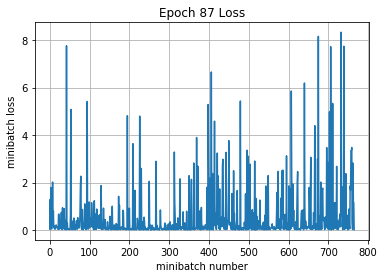

Iteration 66700: with minibatch training loss = 0.00029 and accuracy of 1
Iteration 66800: with minibatch training loss = 0.0144 and accuracy of 1
Iteration 66900: with minibatch training loss = 0.000921 and accuracy of 1
Iteration 67000: with minibatch training loss = 0.000972 and accuracy of 1
Iteration 67100: with minibatch training loss = 0.000207 and accuracy of 1
Iteration 67200: with minibatch training loss = 0.0153 and accuracy of 0.98
Iteration 67300: with minibatch training loss = 0.000251 and accuracy of 1
Iteration 67400: with minibatch training loss = 0.000156 and accuracy of 1
Epoch 88, Overall loss = 0.0116 and accuracy of 0.997


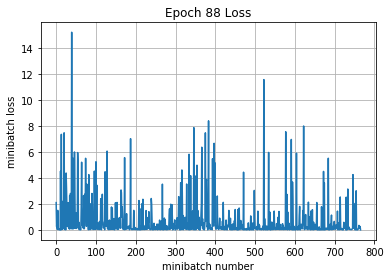

Iteration 67500: with minibatch training loss = 0.0022 and accuracy of 1
Iteration 67600: with minibatch training loss = 0.00193 and accuracy of 1
Iteration 67700: with minibatch training loss = 0.00422 and accuracy of 1
Iteration 67800: with minibatch training loss = 0.000401 and accuracy of 1
Iteration 67900: with minibatch training loss = 0.00184 and accuracy of 1
Iteration 68000: with minibatch training loss = 0.00617 and accuracy of 1
Iteration 68100: with minibatch training loss = 0.0129 and accuracy of 0.98
Epoch 89, Overall loss = 0.0108 and accuracy of 0.997


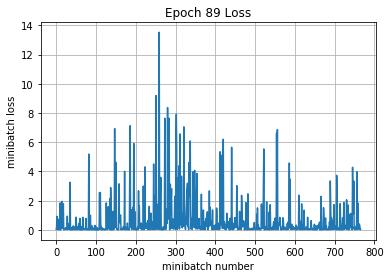

Iteration 68200: with minibatch training loss = 0.00357 and accuracy of 1
Iteration 68300: with minibatch training loss = 0.012 and accuracy of 0.98
Iteration 68400: with minibatch training loss = 0.0429 and accuracy of 0.98
Iteration 68500: with minibatch training loss = 0.0419 and accuracy of 0.97
Iteration 68600: with minibatch training loss = 0.00021 and accuracy of 1
Iteration 68700: with minibatch training loss = 0.00338 and accuracy of 1
Iteration 68800: with minibatch training loss = 0.0674 and accuracy of 0.95
Iteration 68900: with minibatch training loss = 0.00361 and accuracy of 1
Epoch 90, Overall loss = 0.0144 and accuracy of 0.995


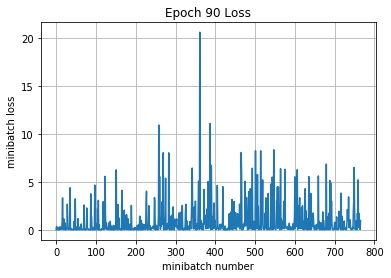

Iteration 69000: with minibatch training loss = 0.00448 and accuracy of 1
Iteration 69100: with minibatch training loss = 0.000155 and accuracy of 1
Iteration 69200: with minibatch training loss = 0.0012 and accuracy of 1
Iteration 69300: with minibatch training loss = 0.00045 and accuracy of 1
Iteration 69400: with minibatch training loss = 0.00284 and accuracy of 1
Iteration 69500: with minibatch training loss = 0.00145 and accuracy of 1
Iteration 69600: with minibatch training loss = 0.000894 and accuracy of 1
Iteration 69700: with minibatch training loss = 0.00147 and accuracy of 1
Epoch 91, Overall loss = 0.0145 and accuracy of 0.995


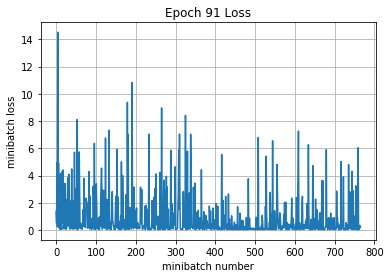

Iteration 69800: with minibatch training loss = 0.00127 and accuracy of 1
Iteration 69900: with minibatch training loss = 0.000281 and accuracy of 1
Iteration 70000: with minibatch training loss = 0.00131 and accuracy of 1
Iteration 70100: with minibatch training loss = 0.00576 and accuracy of 1
Iteration 70200: with minibatch training loss = 0.000124 and accuracy of 1
Iteration 70300: with minibatch training loss = 0.0206 and accuracy of 0.98
Iteration 70400: with minibatch training loss = 0.000144 and accuracy of 1
Epoch 92, Overall loss = 0.00649 and accuracy of 0.998


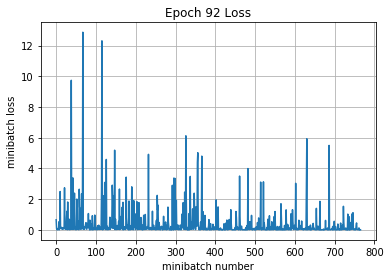

Iteration 70500: with minibatch training loss = 0.0219 and accuracy of 0.98
Iteration 70600: with minibatch training loss = 5.01e-05 and accuracy of 1
Iteration 70700: with minibatch training loss = 0.000117 and accuracy of 1
Iteration 70800: with minibatch training loss = 0.000545 and accuracy of 1
Iteration 70900: with minibatch training loss = 0.00198 and accuracy of 1
Iteration 71000: with minibatch training loss = 0.000105 and accuracy of 1
Iteration 71100: with minibatch training loss = 0.0513 and accuracy of 0.98
Iteration 71200: with minibatch training loss = 0.00139 and accuracy of 1
Epoch 93, Overall loss = 0.0099 and accuracy of 0.997


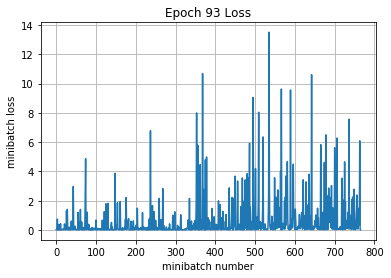

Iteration 71300: with minibatch training loss = 0.000425 and accuracy of 1
Iteration 71400: with minibatch training loss = 0.0439 and accuracy of 0.98
Iteration 71500: with minibatch training loss = 0.00423 and accuracy of 1
Iteration 71600: with minibatch training loss = 0.00367 and accuracy of 1
Iteration 71700: with minibatch training loss = 0.00295 and accuracy of 1
Iteration 71800: with minibatch training loss = 0.000152 and accuracy of 1
Iteration 71900: with minibatch training loss = 0.000933 and accuracy of 1
Iteration 72000: with minibatch training loss = 0.00594 and accuracy of 1
Epoch 94, Overall loss = 0.0129 and accuracy of 0.996


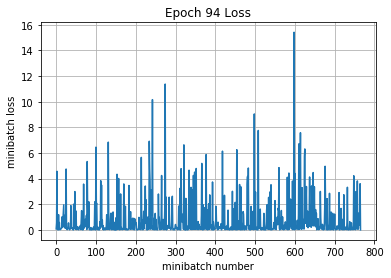

Iteration 72100: with minibatch training loss = 0.00602 and accuracy of 1
Iteration 72200: with minibatch training loss = 0.00014 and accuracy of 1
Iteration 72300: with minibatch training loss = 0.00175 and accuracy of 1
Iteration 72400: with minibatch training loss = 0.00139 and accuracy of 1
Iteration 72500: with minibatch training loss = 0.00193 and accuracy of 1
Iteration 72600: with minibatch training loss = 0.000535 and accuracy of 1
Iteration 72700: with minibatch training loss = 0.00125 and accuracy of 1
Epoch 95, Overall loss = 0.00852 and accuracy of 0.997


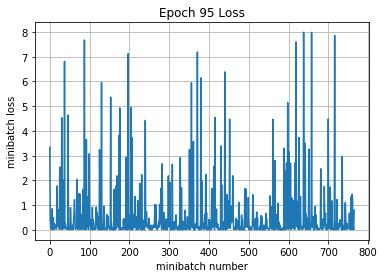

Iteration 72800: with minibatch training loss = 0.00215 and accuracy of 1
Iteration 72900: with minibatch training loss = 0.00745 and accuracy of 1
Iteration 73000: with minibatch training loss = 0.0198 and accuracy of 0.98
Iteration 73100: with minibatch training loss = 0.0229 and accuracy of 0.98
Iteration 73200: with minibatch training loss = 0.0132 and accuracy of 1
Iteration 73300: with minibatch training loss = 0.00436 and accuracy of 1
Iteration 73400: with minibatch training loss = 0.000971 and accuracy of 1
Iteration 73500: with minibatch training loss = 0.000282 and accuracy of 1
Epoch 96, Overall loss = 0.0115 and accuracy of 0.996


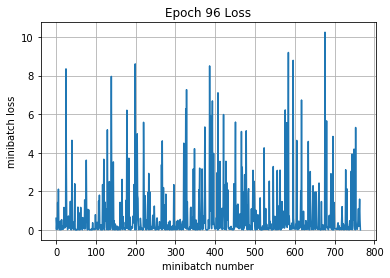

Iteration 73600: with minibatch training loss = 0.00121 and accuracy of 1
Iteration 73700: with minibatch training loss = 0.000408 and accuracy of 1
Iteration 73800: with minibatch training loss = 0.00222 and accuracy of 1
Iteration 73900: with minibatch training loss = 0.000349 and accuracy of 1
Iteration 74000: with minibatch training loss = 0.0192 and accuracy of 0.98
Iteration 74100: with minibatch training loss = 0.000873 and accuracy of 1
Iteration 74200: with minibatch training loss = 0.0208 and accuracy of 0.98
Iteration 74300: with minibatch training loss = 0.000263 and accuracy of 1
Epoch 97, Overall loss = 0.0108 and accuracy of 0.997


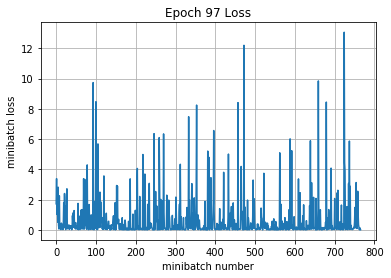

Iteration 74400: with minibatch training loss = 0.0848 and accuracy of 0.97
Iteration 74500: with minibatch training loss = 0.000252 and accuracy of 1
Iteration 74600: with minibatch training loss = 0.00378 and accuracy of 1
Iteration 74700: with minibatch training loss = 0.000217 and accuracy of 1
Iteration 74800: with minibatch training loss = 0.0292 and accuracy of 0.98
Iteration 74900: with minibatch training loss = 0.00038 and accuracy of 1
Iteration 75000: with minibatch training loss = 0.0628 and accuracy of 0.98
Epoch 98, Overall loss = 0.0114 and accuracy of 0.996


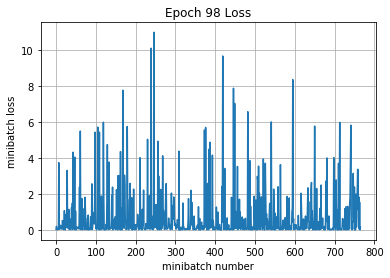

Iteration 75100: with minibatch training loss = 0.0184 and accuracy of 0.98
Iteration 75200: with minibatch training loss = 0.0129 and accuracy of 0.98
Iteration 75300: with minibatch training loss = 0.000209 and accuracy of 1
Iteration 75400: with minibatch training loss = 0.00074 and accuracy of 1
Iteration 75500: with minibatch training loss = 0.00128 and accuracy of 1
Iteration 75600: with minibatch training loss = 0.000244 and accuracy of 1
Iteration 75700: with minibatch training loss = 0.002 and accuracy of 1
Iteration 75800: with minibatch training loss = 0.0114 and accuracy of 1
Epoch 99, Overall loss = 0.00931 and accuracy of 0.997


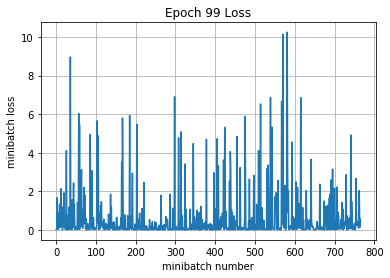

Iteration 75900: with minibatch training loss = 0.02 and accuracy of 0.98
Iteration 76000: with minibatch training loss = 0.000693 and accuracy of 1
Iteration 76100: with minibatch training loss = 0.000584 and accuracy of 1
Iteration 76200: with minibatch training loss = 0.00279 and accuracy of 1
Iteration 76300: with minibatch training loss = 0.00236 and accuracy of 1
Iteration 76400: with minibatch training loss = 0.000913 and accuracy of 1
Iteration 76500: with minibatch training loss = 0.000391 and accuracy of 1
Epoch 100, Overall loss = 0.0117 and accuracy of 0.996


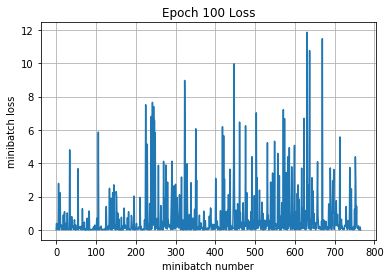

Validation
Epoch 1, Overall loss = 192 and accuracy of 0.824


In [13]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
with tf.device("/gpu:0") as dev:
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    print('Training')
    run_model(sess,y_out,mean_loss,X_train,y_train,100,64,100,train_step,True)
    print('Validation')
    run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

### Describe what you did here
In this cell you should also write an explanation of what you did, any additional features that you implemented, and any visualizations or graphs that you make in the process of training and evaluating your network

In [ ]:
'''
I have implemented a 1-layer network with following architecture:

conv(3 * 3, 96 filters, 1 stride, relu)
            |
conv(2 * 2, 96 filters, 1 stride, relu)            
            | batch_norm
max_pool(2 * 2, 2 strides)
            |
            |
conv(2 * 2, 128 filters, 1 stride, relu)
            |
conv(2 * 2, 128 filters, 1 stride, relu)     
            |
conv(2 * 2, 128 filters, 1 stride, relu)          
            | batch_norm
max_pool(2 * 2, 2 strides)
            |
            |
conv(2 * 2, 256 filters, 1 stride, relu)
            |
conv(2 * 2, 256 filters, 1 stride, relu)  
            |
conv(2 * 2, 256 filters, 1 stride, relu)           
            | batch_norm
max_pool(2 * 2, 2 strides)
            |
            |
conv(2 * 2, 512 filters, 1 stride, relu)
            |
conv(2 * 2, 512 filters, 1 stride, relu)   
            |
conv(2 * 2, 512 filters, 1 stride, relu)           
            | batch_norm
            | flatten
        dense(4096)
            | dropout(p = 0.5)
            | batch_norm
        dense(4096)
            | dropout(p = 0.5)
            | batch_norm
        dense(1024)
            |
         dense(10)
         
With 100 epoches' training, it can achieve a relatively good result (~82%).
'''

### Test Set - Do this only once
Now that we've gotten a result that we're happy with, we test our final model on the test set. This would be the score we would achieve on a competition. Think about how this compares to your validation set accuracy.

In [14]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Test
Epoch 1, Overall loss = 5.18e+03 and accuracy of 0.827


(5180.326332860183, 0.8265)

## Going further with TensorFlow

The next assignment will make heavy use of TensorFlow. You might also find it useful for your projects. 


# Extra Credit Description
If you implement any additional features for extra credit, clearly describe them here with pointers to any code in this or other files if applicable.

### Data Augmentation

I just noticed that the overfit problem reduced the performance of the model above. To solve this problem, one existing common solution is Dropout. Besides, in the paper "ImageNet Classification with Deep Convolutional Neural Networks", another approach was mentioned - data augmentation.

I will implement this method by randomly select 12 * 12 pixels in each image in the original training set and setting them to the maxima in the neighbor pixels (the 6 * 6 submatrix that enclose that pixel). This is equivalent to blurring the original image.


(49000, 32, 32, 3)
(49000,)


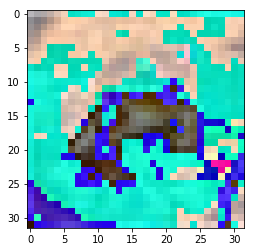

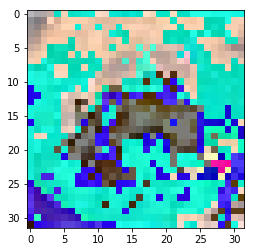

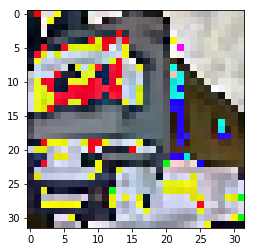

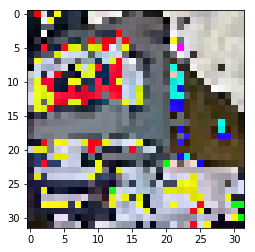

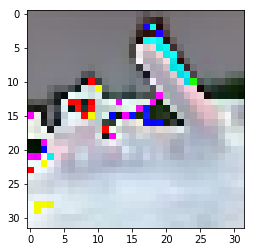

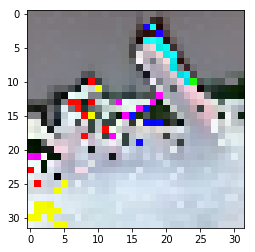

In [36]:
ext_X_train = np.zeros([len(X_train), 32, 32, 3])
ext_y_train = np.zeros(len(X_train))
    
print(ext_X_train.shape)
print(ext_y_train.shape)

for i in range(len(X_train)):
    ind = np.random.choice(32 * 32, 12 * 12, replace = False)
    ext_X_train[i] = X_train[i]
    for t in ind:
        xx = t // 32
        yy = t % 32
        for r in range(3):
            ext_X_train[i, xx, yy, r] = np.max(X_train[i, max(0, xx - 3) : min(32, xx + 3), max(0, yy - 3) : min(32, yy + 3), r])
    ext_y_train[i] = y_train[i]
    
    if (i < 3):
        plt.imshow(X_train[i].astype('uint8'))
        plt.show()
        plt.imshow(ext_X_train[i].astype('uint8'))
        plt.show()
        

In [ ]:
##### This is the previous model without dropout,
## to test whether this method can improve the performance by reducing the overfitting

def my_model_without_dropout(X, y, is_training):
    
    out = tf.layers.conv2d(inputs = X,
                           filters = 96,
                           kernel_size = [4, 4],
                           padding = 'SAME',
                           activation = tf.nn.leaky_relu)
    out = tf.layers.batch_normalization(inputs = out, 
                                        training = is_training)
    
    out = tf.layers.conv2d(inputs = out,
                           filters = 256,
                           kernel_size = [3, 3],
                           padding = 'SAME',
                           activation = tf.nn.leaky_relu)
    out = tf.layers.batch_normalization(inputs = out, 
                                        training = is_training)
    out = tf.layers.max_pooling2d(inputs = out,
                                  pool_size = [2, 2],
                                  strides = 2)
    
    out = tf.layers.conv2d(inputs = out,
                           filters = 384,
                           kernel_size = [2, 2],
                           padding = 'SAME',
                           activation = tf.nn.leaky_relu)
    out = tf.layers.dropout(inputs = out,
                            rate = 0.5)
    
    out = tf.layers.conv2d(inputs = out,
                           filters = 384,
                           kernel_size = [2, 2],
                           padding = 'SAME',
                           activation = tf.nn.leaky_relu)
    out = tf.layers.dropout(inputs = out,
                            rate = 0.5)

    out = tf.layers.conv2d(inputs = out,
                           filters = 256,
                           kernel_size = [2, 2],
                           padding = 'SAME',
                           activation = tf.nn.leaky_relu)
    out = tf.layers.batch_normalization(inputs = out, 
                                        training = is_training)
    out = tf.layers.max_pooling2d(inputs = out,
                                  pool_size = [2, 2],
                                  strides = 2)
    
    out = tf.layers.flatten(inputs = out)
    
    # 4096
    out = tf.layers.dense(inputs = out,
                          units = 4096,
                          activation = tf.nn.relu)
    out = tf.layers.dropout(inputs = out,
                            rate = 0.5)
    out = tf.layers.batch_normalization(inputs = out,
                                        training = is_training)
    
    # 4096
    out = tf.layers.dense(inputs = out,
                          units = 4096,
                          activation = tf.nn.relu)
    out = tf.layers.dropout(inputs = out,
                            rate = 0.5)
    out = tf.layers.batch_normalization(inputs = out,
                                        training = is_training)
    
    # 1024
    out = tf.layers.dense(inputs = out,
                          units = 1024,
                          activation = tf.nn.relu)
    out = tf.layers.dropout(inputs = out,
                            rate = 0.5)
    out = tf.layers.batch_normalization(inputs = out,
                                        training = is_training)
    
    #10
    out = tf.layers.dense(inputs = out,
                          units = 10)

    return out

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model_without_dropout(X, y, is_training)
mean_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = tf.one_hot(y, 10), logits = y_out))
optimizer = tf.train.AdamOptimizer(learning_rate = 1e-3)

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Training_original_dataset
Iteration 0: with minibatch training loss = 3.04 and accuracy of 0.12
Iteration 100: with minibatch training loss = 1.67 and accuracy of 0.5
Iteration 200: with minibatch training loss = 1.45 and accuracy of 0.41
Iteration 300: with minibatch training loss = 1.34 and accuracy of 0.45
Iteration 400: with minibatch training loss = 1.19 and accuracy of 0.59
Iteration 500: with minibatch training loss = 1.27 and accuracy of 0.64
Iteration 600: with minibatch training loss = 1.2 and accuracy of 0.61
Iteration 700: with minibatch training loss = 1.3 and accuracy of 0.62
Epoch 1, Overall loss = 1.37 and accuracy of 0.526


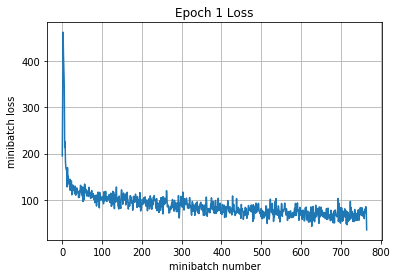

Iteration 800: with minibatch training loss = 1.22 and accuracy of 0.62
Iteration 900: with minibatch training loss = 0.739 and accuracy of 0.75
Iteration 1000: with minibatch training loss = 0.987 and accuracy of 0.66
Iteration 1100: with minibatch training loss = 1.02 and accuracy of 0.72
Iteration 1200: with minibatch training loss = 0.671 and accuracy of 0.8
Iteration 1300: with minibatch training loss = 0.915 and accuracy of 0.67
Iteration 1400: with minibatch training loss = 0.51 and accuracy of 0.83
Iteration 1500: with minibatch training loss = 0.714 and accuracy of 0.75
Epoch 2, Overall loss = 0.895 and accuracy of 0.69


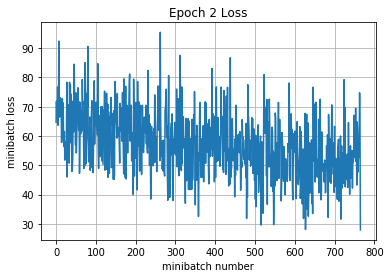

Iteration 1600: with minibatch training loss = 1.04 and accuracy of 0.67
Iteration 1700: with minibatch training loss = 0.944 and accuracy of 0.58
Iteration 1800: with minibatch training loss = 0.746 and accuracy of 0.75
Iteration 1900: with minibatch training loss = 0.574 and accuracy of 0.83
Iteration 2000: with minibatch training loss = 0.842 and accuracy of 0.78
Iteration 2100: with minibatch training loss = 0.739 and accuracy of 0.73
Iteration 2200: with minibatch training loss = 0.867 and accuracy of 0.73
Epoch 3, Overall loss = 0.707 and accuracy of 0.756


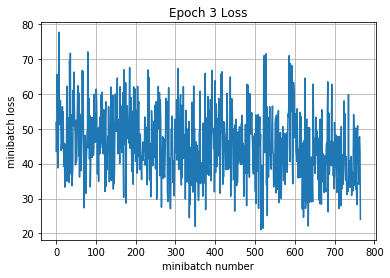

Iteration 2300: with minibatch training loss = 0.652 and accuracy of 0.81
Iteration 2400: with minibatch training loss = 0.709 and accuracy of 0.69
Iteration 2500: with minibatch training loss = 0.658 and accuracy of 0.8
Iteration 2600: with minibatch training loss = 0.493 and accuracy of 0.81
Iteration 2700: with minibatch training loss = 0.586 and accuracy of 0.83
Iteration 2800: with minibatch training loss = 0.734 and accuracy of 0.7
Iteration 2900: with minibatch training loss = 0.497 and accuracy of 0.8
Iteration 3000: with minibatch training loss = 0.431 and accuracy of 0.86
Epoch 4, Overall loss = 0.56 and accuracy of 0.808


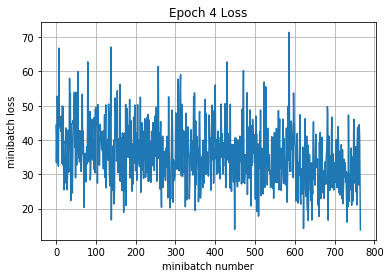

Iteration 3100: with minibatch training loss = 0.565 and accuracy of 0.81
Iteration 3200: with minibatch training loss = 0.501 and accuracy of 0.81
Iteration 3300: with minibatch training loss = 0.398 and accuracy of 0.86
Iteration 3400: with minibatch training loss = 0.424 and accuracy of 0.91
Iteration 3500: with minibatch training loss = 0.461 and accuracy of 0.83
Iteration 3600: with minibatch training loss = 0.368 and accuracy of 0.86
Iteration 3700: with minibatch training loss = 0.295 and accuracy of 0.89
Iteration 3800: with minibatch training loss = 0.422 and accuracy of 0.81
Epoch 5, Overall loss = 0.429 and accuracy of 0.851


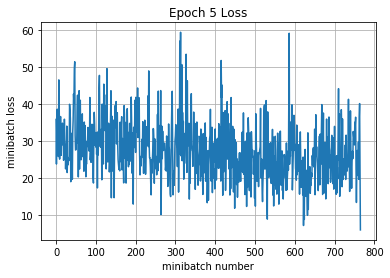

Iteration 3900: with minibatch training loss = 0.34 and accuracy of 0.88
Iteration 4000: with minibatch training loss = 0.184 and accuracy of 0.97
Iteration 4100: with minibatch training loss = 0.382 and accuracy of 0.84
Iteration 4200: with minibatch training loss = 0.358 and accuracy of 0.91
Iteration 4300: with minibatch training loss = 0.501 and accuracy of 0.86
Iteration 4400: with minibatch training loss = 0.538 and accuracy of 0.86
Iteration 4500: with minibatch training loss = 0.382 and accuracy of 0.84
Epoch 6, Overall loss = 0.344 and accuracy of 0.881


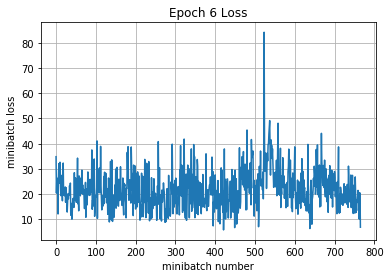

Iteration 4600: with minibatch training loss = 0.24 and accuracy of 0.92
Iteration 4700: with minibatch training loss = 0.309 and accuracy of 0.86
Iteration 4800: with minibatch training loss = 0.0883 and accuracy of 0.98
Iteration 4900: with minibatch training loss = 0.228 and accuracy of 0.89
Iteration 5000: with minibatch training loss = 0.205 and accuracy of 0.95
Iteration 5100: with minibatch training loss = 0.272 and accuracy of 0.92
Iteration 5200: with minibatch training loss = 0.168 and accuracy of 0.94
Iteration 5300: with minibatch training loss = 0.267 and accuracy of 0.92
Epoch 7, Overall loss = 0.247 and accuracy of 0.914


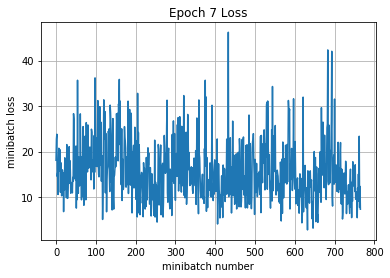

Iteration 5400: with minibatch training loss = 0.124 and accuracy of 0.97
Iteration 5500: with minibatch training loss = 0.0691 and accuracy of 0.98
Iteration 5600: with minibatch training loss = 0.259 and accuracy of 0.89
Iteration 5700: with minibatch training loss = 0.243 and accuracy of 0.89
Iteration 5800: with minibatch training loss = 0.185 and accuracy of 0.89
Iteration 5900: with minibatch training loss = 0.342 and accuracy of 0.91
Iteration 6000: with minibatch training loss = 0.071 and accuracy of 0.97
Iteration 6100: with minibatch training loss = 0.218 and accuracy of 0.94
Epoch 8, Overall loss = 0.195 and accuracy of 0.932


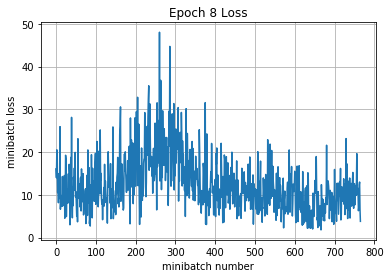

Iteration 6200: with minibatch training loss = 0.0877 and accuracy of 0.98
Iteration 6300: with minibatch training loss = 0.215 and accuracy of 0.92
Iteration 6400: with minibatch training loss = 0.143 and accuracy of 0.95
Iteration 6500: with minibatch training loss = 0.0665 and accuracy of 0.97
Iteration 6600: with minibatch training loss = 0.0997 and accuracy of 0.95
Iteration 6700: with minibatch training loss = 0.0404 and accuracy of 1
Iteration 6800: with minibatch training loss = 0.0593 and accuracy of 0.98
Epoch 9, Overall loss = 0.122 and accuracy of 0.958


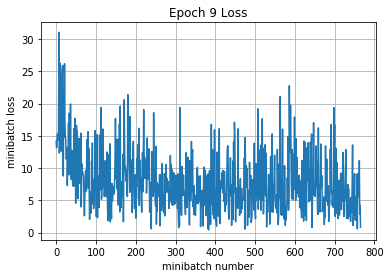

Iteration 6900: with minibatch training loss = 0.0662 and accuracy of 0.98
Iteration 7000: with minibatch training loss = 0.039 and accuracy of 0.98
Iteration 7100: with minibatch training loss = 0.111 and accuracy of 0.94
Iteration 7200: with minibatch training loss = 0.328 and accuracy of 0.88
Iteration 7300: with minibatch training loss = 0.0968 and accuracy of 0.98
Iteration 7400: with minibatch training loss = 0.0944 and accuracy of 0.98
Iteration 7500: with minibatch training loss = 0.0772 and accuracy of 0.97
Iteration 7600: with minibatch training loss = 0.0255 and accuracy of 0.98
Epoch 10, Overall loss = 0.109 and accuracy of 0.963


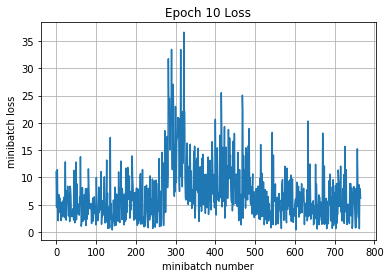

In [9]:
## train on original dataset

with tf.device("/gpu:0") as dev:
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    print('Training_original_dataset')
    run_model(sess,y_out,mean_loss,X_train,y_train,10,64,100,train_step,True)

In [12]:
print('Validation_original_dataset')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
print('Test_original_dataset')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Validation_original_dataset
Epoch 1, Overall loss = 1.39 and accuracy of 0.723
Test_original_dataset
Epoch 1, Overall loss = 1.31 and accuracy of 0.715


(1.3113150054931642, 0.7153)

Training_original+extended_dataset
Iteration 0: with minibatch training loss = 3.11 and accuracy of 0.094
Iteration 100: with minibatch training loss = 1.97 and accuracy of 0.33
Iteration 200: with minibatch training loss = 1.84 and accuracy of 0.38
Iteration 300: with minibatch training loss = 1.21 and accuracy of 0.56
Iteration 400: with minibatch training loss = 1.79 and accuracy of 0.41
Iteration 500: with minibatch training loss = 1.46 and accuracy of 0.45
Iteration 600: with minibatch training loss = 1.34 and accuracy of 0.62
Iteration 700: with minibatch training loss = 1.24 and accuracy of 0.55
Iteration 800: with minibatch training loss = 1.05 and accuracy of 0.67
Iteration 900: with minibatch training loss = 1.12 and accuracy of 0.59
Iteration 1000: with minibatch training loss = 0.762 and accuracy of 0.73
Iteration 1100: with minibatch training loss = 1.21 and accuracy of 0.53
Iteration 1200: with minibatch training loss = 1.08 and accuracy of 0.61
Iteration 1300: with minib

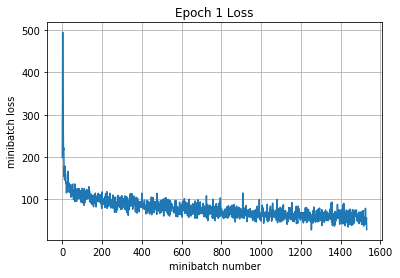

Iteration 1600: with minibatch training loss = 1.22 and accuracy of 0.56
Iteration 1700: with minibatch training loss = 0.676 and accuracy of 0.8
Iteration 1800: with minibatch training loss = 0.713 and accuracy of 0.81
Iteration 1900: with minibatch training loss = 0.554 and accuracy of 0.73
Iteration 2000: with minibatch training loss = 0.672 and accuracy of 0.72
Iteration 2100: with minibatch training loss = 0.824 and accuracy of 0.72
Iteration 2200: with minibatch training loss = 0.978 and accuracy of 0.69
Iteration 2300: with minibatch training loss = 0.414 and accuracy of 0.86
Iteration 2400: with minibatch training loss = 0.885 and accuracy of 0.69
Iteration 2500: with minibatch training loss = 0.69 and accuracy of 0.72
Iteration 2600: with minibatch training loss = 0.591 and accuracy of 0.77
Iteration 2700: with minibatch training loss = 0.839 and accuracy of 0.69
Iteration 2800: with minibatch training loss = 0.49 and accuracy of 0.81
Iteration 2900: with minibatch training lo

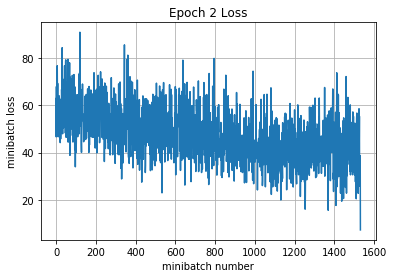

Iteration 3100: with minibatch training loss = 0.656 and accuracy of 0.78
Iteration 3200: with minibatch training loss = 0.588 and accuracy of 0.77
Iteration 3300: with minibatch training loss = 0.516 and accuracy of 0.88
Iteration 3400: with minibatch training loss = 0.428 and accuracy of 0.88
Iteration 3500: with minibatch training loss = 0.617 and accuracy of 0.75
Iteration 3600: with minibatch training loss = 0.834 and accuracy of 0.78
Iteration 3700: with minibatch training loss = 0.381 and accuracy of 0.83
Iteration 3800: with minibatch training loss = 0.437 and accuracy of 0.86
Iteration 3900: with minibatch training loss = 0.428 and accuracy of 0.86
Iteration 4000: with minibatch training loss = 0.5 and accuracy of 0.84
Iteration 4100: with minibatch training loss = 0.259 and accuracy of 0.91
Iteration 4200: with minibatch training loss = 0.58 and accuracy of 0.8
Iteration 4300: with minibatch training loss = 0.39 and accuracy of 0.84
Iteration 4400: with minibatch training los

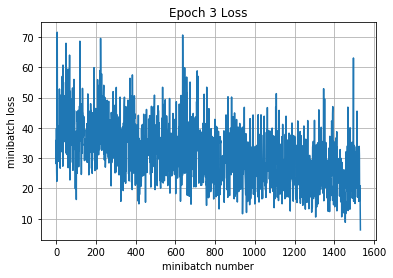

Iteration 4600: with minibatch training loss = 0.215 and accuracy of 0.95
Iteration 4700: with minibatch training loss = 0.429 and accuracy of 0.86
Iteration 4800: with minibatch training loss = 0.442 and accuracy of 0.84
Iteration 4900: with minibatch training loss = 0.216 and accuracy of 0.91
Iteration 5000: with minibatch training loss = 0.258 and accuracy of 0.94
Iteration 5100: with minibatch training loss = 0.287 and accuracy of 0.91
Iteration 5200: with minibatch training loss = 0.344 and accuracy of 0.84
Iteration 5300: with minibatch training loss = 0.308 and accuracy of 0.88
Iteration 5400: with minibatch training loss = 0.232 and accuracy of 0.94
Iteration 5500: with minibatch training loss = 0.198 and accuracy of 0.94
Iteration 5600: with minibatch training loss = 0.148 and accuracy of 0.95
Iteration 5700: with minibatch training loss = 0.0675 and accuracy of 0.97
Iteration 5800: with minibatch training loss = 0.323 and accuracy of 0.86
Iteration 5900: with minibatch traini

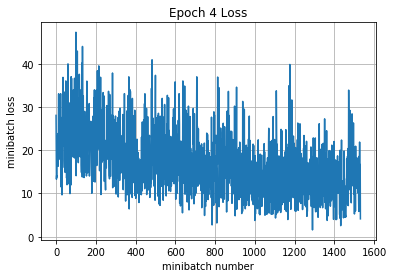

Iteration 6200: with minibatch training loss = 0.23 and accuracy of 0.94
Iteration 6300: with minibatch training loss = 0.187 and accuracy of 0.94
Iteration 6400: with minibatch training loss = 0.127 and accuracy of 0.95
Iteration 6500: with minibatch training loss = 0.262 and accuracy of 0.91
Iteration 6600: with minibatch training loss = 0.0325 and accuracy of 0.98
Iteration 6700: with minibatch training loss = 0.339 and accuracy of 0.86
Iteration 6800: with minibatch training loss = 0.18 and accuracy of 0.94
Iteration 6900: with minibatch training loss = 0.146 and accuracy of 0.95
Iteration 7000: with minibatch training loss = 0.114 and accuracy of 0.97
Iteration 7100: with minibatch training loss = 0.254 and accuracy of 0.94
Iteration 7200: with minibatch training loss = 0.126 and accuracy of 0.97
Iteration 7300: with minibatch training loss = 0.253 and accuracy of 0.94
Iteration 7400: with minibatch training loss = 0.0617 and accuracy of 0.97
Iteration 7500: with minibatch trainin

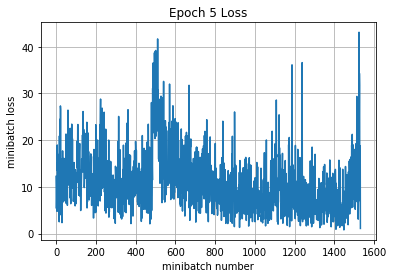

Iteration 7700: with minibatch training loss = 0.184 and accuracy of 0.92
Iteration 7800: with minibatch training loss = 0.109 and accuracy of 0.98
Iteration 7900: with minibatch training loss = 0.125 and accuracy of 0.97
Iteration 8000: with minibatch training loss = 0.0767 and accuracy of 0.97
Iteration 8100: with minibatch training loss = 0.041 and accuracy of 0.97
Iteration 8200: with minibatch training loss = 0.119 and accuracy of 0.98
Iteration 8300: with minibatch training loss = 0.253 and accuracy of 0.94
Iteration 8400: with minibatch training loss = 0.189 and accuracy of 0.97
Iteration 8500: with minibatch training loss = 0.078 and accuracy of 0.95
Iteration 8600: with minibatch training loss = 0.0947 and accuracy of 0.97
Iteration 8700: with minibatch training loss = 0.193 and accuracy of 0.97
Iteration 8800: with minibatch training loss = 0.0571 and accuracy of 0.97
Iteration 8900: with minibatch training loss = 0.00801 and accuracy of 1
Iteration 9000: with minibatch train

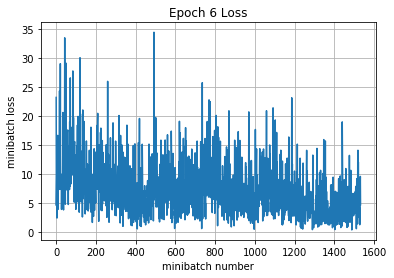

Iteration 9200: with minibatch training loss = 0.0543 and accuracy of 0.98
Iteration 9300: with minibatch training loss = 0.109 and accuracy of 0.97
Iteration 9400: with minibatch training loss = 0.0973 and accuracy of 0.94
Iteration 9500: with minibatch training loss = 0.352 and accuracy of 0.89
Iteration 9600: with minibatch training loss = 0.178 and accuracy of 0.97
Iteration 9700: with minibatch training loss = 0.0107 and accuracy of 1
Iteration 9800: with minibatch training loss = 0.148 and accuracy of 0.97
Iteration 9900: with minibatch training loss = 0.206 and accuracy of 0.95
Iteration 10000: with minibatch training loss = 0.0584 and accuracy of 0.95
Iteration 10100: with minibatch training loss = 0.262 and accuracy of 0.95
Iteration 10200: with minibatch training loss = 0.0894 and accuracy of 0.94
Iteration 10300: with minibatch training loss = 0.0232 and accuracy of 1
Iteration 10400: with minibatch training loss = 0.0847 and accuracy of 0.98
Iteration 10500: with minibatch 

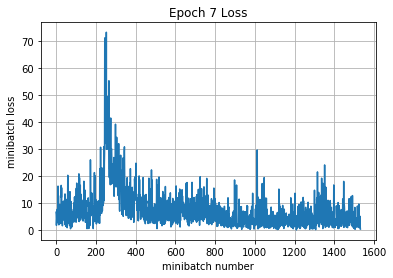

Iteration 10800: with minibatch training loss = 0.162 and accuracy of 0.95
Iteration 10900: with minibatch training loss = 0.0299 and accuracy of 1
Iteration 11000: with minibatch training loss = 0.101 and accuracy of 0.95
Iteration 11100: with minibatch training loss = 0.0162 and accuracy of 1
Iteration 11200: with minibatch training loss = 0.0517 and accuracy of 0.97
Iteration 11300: with minibatch training loss = 0.117 and accuracy of 0.95
Iteration 11400: with minibatch training loss = 0.0237 and accuracy of 1
Iteration 11500: with minibatch training loss = 0.192 and accuracy of 0.95
Iteration 11600: with minibatch training loss = 0.0947 and accuracy of 0.95
Iteration 11700: with minibatch training loss = 0.0232 and accuracy of 1
Iteration 11800: with minibatch training loss = 0.0275 and accuracy of 0.98
Iteration 11900: with minibatch training loss = 0.0495 and accuracy of 0.98
Iteration 12000: with minibatch training loss = 0.113 and accuracy of 0.95
Iteration 12100: with minibat

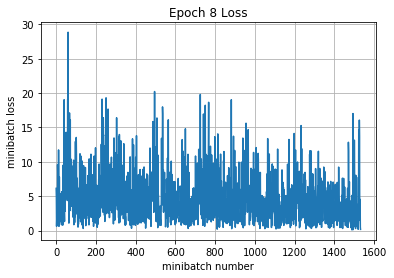

Iteration 12300: with minibatch training loss = 0.0594 and accuracy of 0.98
Iteration 12400: with minibatch training loss = 0.0177 and accuracy of 0.98
Iteration 12500: with minibatch training loss = 0.0177 and accuracy of 1
Iteration 12600: with minibatch training loss = 0.0501 and accuracy of 0.98
Iteration 12700: with minibatch training loss = 0.0453 and accuracy of 0.97
Iteration 12800: with minibatch training loss = 0.0675 and accuracy of 0.97
Iteration 12900: with minibatch training loss = 0.138 and accuracy of 0.95
Iteration 13000: with minibatch training loss = 0.212 and accuracy of 0.95
Iteration 13100: with minibatch training loss = 0.168 and accuracy of 0.95
Iteration 13200: with minibatch training loss = 0.0356 and accuracy of 0.98
Iteration 13300: with minibatch training loss = 0.0113 and accuracy of 1
Iteration 13400: with minibatch training loss = 0.041 and accuracy of 0.98
Iteration 13500: with minibatch training loss = 0.205 and accuracy of 0.95
Iteration 13600: with m

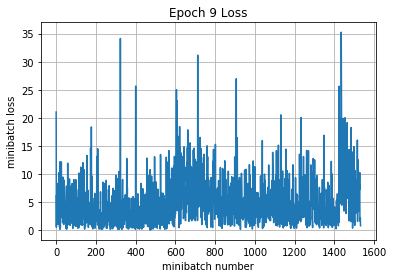

Iteration 13800: with minibatch training loss = 0.0306 and accuracy of 0.98
Iteration 13900: with minibatch training loss = 0.154 and accuracy of 0.95
Iteration 14000: with minibatch training loss = 0.0279 and accuracy of 0.97
Iteration 14100: with minibatch training loss = 0.0835 and accuracy of 0.97
Iteration 14200: with minibatch training loss = 0.115 and accuracy of 0.97
Iteration 14300: with minibatch training loss = 0.0635 and accuracy of 0.98
Iteration 14400: with minibatch training loss = 0.0313 and accuracy of 0.98
Iteration 14500: with minibatch training loss = 0.0642 and accuracy of 0.95
Iteration 14600: with minibatch training loss = 0.197 and accuracy of 0.95
Iteration 14700: with minibatch training loss = 0.0511 and accuracy of 0.97
Iteration 14800: with minibatch training loss = 0.227 and accuracy of 0.97
Iteration 14900: with minibatch training loss = 0.0666 and accuracy of 0.98
Iteration 15000: with minibatch training loss = 0.0275 and accuracy of 1
Iteration 15100: wi

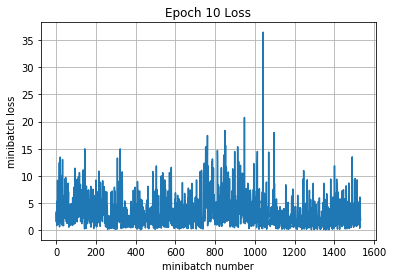

In [47]:
## train on original dataset + extended dataset

with tf.device("/gpu:0") as dev:
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    print('Training_original+extended_dataset')
    X_new = np.append(X_train, ext_X_train, axis = 0)
    y_new = np.append(y_train, ext_y_train, axis = 0)
    run_model(sess,y_out,mean_loss,X_new,y_new,10,64,100,train_step,True)     

In [48]:
print('Validation_original+extended_dataset')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)
print('Validation_original+extended_dataset')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

Validation_original+extended_dataset
Epoch 1, Overall loss = 1.47 and accuracy of 0.736
Validation_original+extended_dataset
Epoch 1, Overall loss = 1.52 and accuracy of 0.738


(1.5187454572677612, 0.7383)

## Result

We can clearly see that after data augmentation, the performance of the model improved by ~2%.  However, since the dataset was doubled, this method is no cheap compared to its improvement.